<a href="https://colab.research.google.com/github/NilBeserler/COGS181_FinalProject/blob/main/LFW%2BCNN_%2B_RESNET_(workingversion)_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

#!pip install keras scikit-learn imbalanced-learn

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data_utils
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms
import torchvision.models as models

from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix



In [ ]:
# Load LFW dataset from scikit-learn
lfw_people = fetch_lfw_people(min_faces_per_person=20, color=True, resize=1.0,
                              slice_=(slice(48, 202), slice(48, 202)))
X = lfw_people.images
y = lfw_people.target

# Convert data to torch tensors and normalize pixel values
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
X = torch.stack([transform(img) for img in X])
y = torch.tensor(y)

# Split dataset into train and test sets
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)


# Create a data loader for the train set
train_dataset = TensorDataset(train_X, train_y)
trainloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(test_X, test_y)
testloader = DataLoader(test_dataset, batch_size=32, shuffle=False)



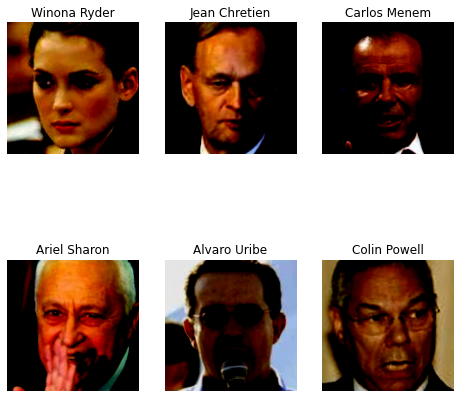

In [ ]:
target_names = lfw_people.target_names
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(8, 8))
for i in range(6):
    ax = axs[i // 3, i % 3]
    ax.imshow(X[i].permute(1, 2, 0))
    ax.set_title(target_names[y[i]])
    ax.axis('off')
plt.show()

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)  

cpu


In [ ]:
n_classes = len(np.unique(test_y))
print('Number of classes:', n_classes)


Number of classes: 62


In [ ]:
#@title RNN expanded form

"""
import torch.nn as nn
import torchvision.models as models

class ResNet18(nn.Module):

    def __init__(self, num_classes=62):
        super(ResNet18, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        self.resnet.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)

        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x = self.resnet.layer3(x)
        x = self.resnet.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

net = ResNet18()
net.to(device)
"""


'\nimport torch.nn as nn\nimport torchvision.models as models\n\nclass ResNet18(nn.Module):\n\n    def __init__(self, num_classes=62):\n        super(ResNet18, self).__init__()\n        self.resnet = models.resnet18(pretrained=True)\n        self.resnet.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)\n        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))\n        self.fc = nn.Linear(512, num_classes)\n\n    def forward(self, x):\n        x = self.resnet.conv1(x)\n        x = self.resnet.bn1(x)\n        x = self.resnet.relu(x)\n        x = self.resnet.maxpool(x)\n\n        x = self.resnet.layer1(x)\n        x = self.resnet.layer2(x)\n        x = self.resnet.layer3(x)\n        x = self.resnet.layer4(x)\n\n        x = self.avgpool(x)\n        x = torch.flatten(x, 1)\n        x = self.fc(x)\n\n        return x\n\nnet = ResNet18()\nnet.to(device)\n'

In [ ]:
'''
import torchvision.models as models

# Initialize ResNet18.
net = models.resnet18(pretrained=True)

# Replace last layer.
num_classes = len(torch.unique(y))
net.fc = nn.Linear(net.fc.in_features, num_classes)

'''



'\nimport torchvision.models as models\n\n# Initialize ResNet18.\nnet = models.resnet18(pretrained=True)\n\n# Replace last layer.\nnum_classes = len(torch.unique(y))\nnet.fc = nn.Linear(net.fc.in_features, num_classes)\n\n'

To fix this, you should modify the forward method of the ResNet50 class to include a global average pooling layer after the convolutional layers and before the fully connected layer. This will reduce the dimensions of the output from the convolutional layers to (batch_size, num_channels) and allow it to be multiplied with the weight matrix of the fully connected layer.

the architecture is still ResNet50. The only difference is that the fully connected layer (fc) at the end of the ResNet50 has been modified to output num_classes (which is 62 in this case) instead of the default output of 1000 for ImageNet classification.


In [ ]:


import torch.nn as nn

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 19 * 19, 512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 62)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = self.pool(nn.functional.relu(self.conv3(x)))
        x = x.view(-1, 64 * 19 * 19)
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

net = Net()
net.to(device)



Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=23104, out_features=512, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=62, bias=True)
)

In [ ]:
# We use cross-entropy as loss function.
#loss_func = nn.CrossEntropyLoss()  
# We use stochastic gradient descent (SGD) as optimizer.
#opt = optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999))

In [ ]:
#print(input.shape)

In [ ]:
"""
#Training for Resnet18 
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18
from tqdm import tqdm
import matplotlib.pyplot as plt


# Define the loss function.
loss_func = nn.CrossEntropyLoss()

# Define the optimizer.
#opt = optim.Adam(net.parameters(), lr=0.001)
opt = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

avg_losses = []   # Avg. losses.
epochs = 10       # Total epochs.
print_freq = 1  # Print frequency.

for epoch in range(epochs):  # Loop over the dataset multiple times.
    running_loss = 0.0       # Initialize running loss.
    pbar = tqdm(trainloader, desc=f"Epoch {epoch}") # Create a progress bar
    for i, data in enumerate(pbar):
        # Get the inputs.
        inputs, labels = data
        
        # Move the inputs to the specified device.
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients.
        opt.zero_grad()

        # Forward step.
        outputs = net(inputs)
        loss = loss_func(outputs, labels)
        
        # Backward step.
        loss.backward()
        
        # Optimization step (update the parameters).
        opt.step()

        # Print statistics.
        running_loss += loss.item()
        pbar.set_postfix({"Avg Loss": f"{running_loss / (i+1):.3f}"}) # Update the progress bar
        if i % print_freq == print_freq - 1: # Print every several mini-batches.
            avg_loss = running_loss / print_freq
            print('[epoch: {}, i: {:5d}] avg mini-batch loss: {:.3f}'.format(
                epoch, i, avg_loss))
            avg_losses.append(avg_loss)
            running_loss = 0.0

print('Finished Training.')

# Plot the average loss graph.
plt.figure()
plt.plot(avg_losses)
plt.title('Average Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Average Loss')
plt.show()
"""


'\n#Training for Resnet18 \nimport torch.nn as nn\nimport torch.optim as optim\nfrom torchvision.models import resnet18\nfrom tqdm import tqdm\nimport matplotlib.pyplot as plt\n\n\n# Define the loss function.\nloss_func = nn.CrossEntropyLoss()\n\n# Define the optimizer.\n#opt = optim.Adam(net.parameters(), lr=0.001)\nopt = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)\n\navg_losses = []   # Avg. losses.\nepochs = 10       # Total epochs.\nprint_freq = 1  # Print frequency.\n\nfor epoch in range(epochs):  # Loop over the dataset multiple times.\n    running_loss = 0.0       # Initialize running loss.\n    pbar = tqdm(trainloader, desc=f"Epoch {epoch}") # Create a progress bar\n    for i, data in enumerate(pbar):\n        # Get the inputs.\n        inputs, labels = data\n        \n        # Move the inputs to the specified device.\n        inputs, labels = inputs.to(device), labels.to(device)\n        \n        # Zero the parameter gradients.\n        opt.zero_grad()\n\n        # F

Epoch 0:   1%|▏         | 1/76 [00:00<01:00,  1.23it/s, Avg Loss=4.127]

[epoch: 0, i:     0] avg mini-batch loss: 4.127


Epoch 0:   3%|▎         | 2/76 [00:01<00:56,  1.32it/s, Avg Loss=2.060]

[epoch: 0, i:     1] avg mini-batch loss: 4.120


Epoch 0:   4%|▍         | 3/76 [00:02<00:50,  1.44it/s, Avg Loss=1.373]

[epoch: 0, i:     2] avg mini-batch loss: 4.120


Epoch 0:   5%|▌         | 4/76 [00:02<00:49,  1.46it/s, Avg Loss=1.027]

[epoch: 0, i:     3] avg mini-batch loss: 4.107


Epoch 0:   7%|▋         | 5/76 [00:03<00:49,  1.44it/s, Avg Loss=0.823]

[epoch: 0, i:     4] avg mini-batch loss: 4.114


Epoch 0:   8%|▊         | 6/76 [00:04<00:48,  1.45it/s, Avg Loss=0.683]

[epoch: 0, i:     5] avg mini-batch loss: 4.098


Epoch 0:   9%|▉         | 7/76 [00:04<00:48,  1.43it/s, Avg Loss=0.584]

[epoch: 0, i:     6] avg mini-batch loss: 4.090


Epoch 0:  11%|█         | 8/76 [00:05<00:45,  1.48it/s, Avg Loss=0.508]

[epoch: 0, i:     7] avg mini-batch loss: 4.064


Epoch 0:  12%|█▏        | 9/76 [00:06<00:45,  1.49it/s, Avg Loss=0.453]

[epoch: 0, i:     8] avg mini-batch loss: 4.075


Epoch 0:  13%|█▎        | 10/76 [00:07<00:52,  1.26it/s, Avg Loss=0.402]

[epoch: 0, i:     9] avg mini-batch loss: 4.020


Epoch 0:  14%|█▍        | 11/76 [00:08<00:57,  1.14it/s, Avg Loss=0.362]

[epoch: 0, i:    10] avg mini-batch loss: 3.979


Epoch 0:  16%|█▌        | 12/76 [00:09<01:09,  1.08s/it, Avg Loss=0.334]

[epoch: 0, i:    11] avg mini-batch loss: 4.011


Epoch 0:  17%|█▋        | 13/76 [00:11<01:21,  1.29s/it, Avg Loss=0.303]

[epoch: 0, i:    12] avg mini-batch loss: 3.945


Epoch 0:  18%|█▊        | 14/76 [00:12<01:15,  1.22s/it, Avg Loss=0.277]

[epoch: 0, i:    13] avg mini-batch loss: 3.883


Epoch 0:  20%|█▉        | 15/76 [00:13<01:13,  1.20s/it, Avg Loss=0.250]

[epoch: 0, i:    14] avg mini-batch loss: 3.746


Epoch 0:  21%|██        | 16/76 [00:15<01:21,  1.36s/it, Avg Loss=0.245]

[epoch: 0, i:    15] avg mini-batch loss: 3.918


Epoch 0:  22%|██▏       | 17/76 [00:17<01:26,  1.47s/it, Avg Loss=0.205]

[epoch: 0, i:    16] avg mini-batch loss: 3.478


Epoch 0:  24%|██▎       | 18/76 [00:18<01:28,  1.52s/it, Avg Loss=0.228]

[epoch: 0, i:    17] avg mini-batch loss: 4.110


Epoch 0:  25%|██▌       | 19/76 [00:20<01:24,  1.47s/it, Avg Loss=0.192]

[epoch: 0, i:    18] avg mini-batch loss: 3.640


Epoch 0:  26%|██▋       | 20/76 [00:21<01:16,  1.36s/it, Avg Loss=0.181]

[epoch: 0, i:    19] avg mini-batch loss: 3.622


Epoch 0:  28%|██▊       | 21/76 [00:22<01:09,  1.26s/it, Avg Loss=0.174]

[epoch: 0, i:    20] avg mini-batch loss: 3.660


Epoch 0:  29%|██▉       | 22/76 [00:23<00:58,  1.09s/it, Avg Loss=0.175]

[epoch: 0, i:    21] avg mini-batch loss: 3.843


Epoch 0:  30%|███       | 23/76 [00:23<00:52,  1.01it/s, Avg Loss=0.160]

[epoch: 0, i:    22] avg mini-batch loss: 3.679


Epoch 0:  32%|███▏      | 24/76 [00:24<00:47,  1.10it/s, Avg Loss=0.153]

[epoch: 0, i:    23] avg mini-batch loss: 3.664


Epoch 0:  33%|███▎      | 25/76 [00:25<00:43,  1.18it/s, Avg Loss=0.141]

[epoch: 0, i:    24] avg mini-batch loss: 3.524


Epoch 0:  34%|███▍      | 26/76 [00:25<00:39,  1.28it/s, Avg Loss=0.145]

[epoch: 0, i:    25] avg mini-batch loss: 3.783


Epoch 0:  36%|███▌      | 27/76 [00:26<00:36,  1.35it/s, Avg Loss=0.141]

[epoch: 0, i:    26] avg mini-batch loss: 3.810


Epoch 0:  37%|███▋      | 28/76 [00:27<00:35,  1.37it/s, Avg Loss=0.136]

[epoch: 0, i:    27] avg mini-batch loss: 3.814


Epoch 0:  38%|███▊      | 29/76 [00:28<00:34,  1.37it/s, Avg Loss=0.134]

[epoch: 0, i:    28] avg mini-batch loss: 3.889


Epoch 0:  39%|███▉      | 30/76 [00:28<00:33,  1.36it/s, Avg Loss=0.116]

[epoch: 0, i:    29] avg mini-batch loss: 3.484


Epoch 0:  41%|████      | 31/76 [00:29<00:32,  1.38it/s, Avg Loss=0.130]

[epoch: 0, i:    30] avg mini-batch loss: 4.015


Epoch 0:  42%|████▏     | 32/76 [00:30<00:30,  1.44it/s, Avg Loss=0.113]

[epoch: 0, i:    31] avg mini-batch loss: 3.612


Epoch 0:  43%|████▎     | 33/76 [00:31<00:34,  1.23it/s, Avg Loss=0.114]

[epoch: 0, i:    32] avg mini-batch loss: 3.759


Epoch 0:  45%|████▍     | 34/76 [00:31<00:32,  1.27it/s, Avg Loss=0.113]

[epoch: 0, i:    33] avg mini-batch loss: 3.850


Epoch 0:  46%|████▌     | 35/76 [00:32<00:33,  1.24it/s, Avg Loss=0.104]

[epoch: 0, i:    34] avg mini-batch loss: 3.628


Epoch 0:  47%|████▋     | 36/76 [00:33<00:35,  1.11it/s, Avg Loss=0.110]

[epoch: 0, i:    35] avg mini-batch loss: 3.947


Epoch 0:  49%|████▊     | 37/76 [00:34<00:36,  1.06it/s, Avg Loss=0.102]

[epoch: 0, i:    36] avg mini-batch loss: 3.789


Epoch 0:  50%|█████     | 38/76 [00:35<00:33,  1.13it/s, Avg Loss=0.096]

[epoch: 0, i:    37] avg mini-batch loss: 3.656


Epoch 0:  51%|█████▏    | 39/76 [00:36<00:29,  1.24it/s, Avg Loss=0.091]

[epoch: 0, i:    38] avg mini-batch loss: 3.552


Epoch 0:  53%|█████▎    | 40/76 [00:36<00:27,  1.32it/s, Avg Loss=0.095]

[epoch: 0, i:    39] avg mini-batch loss: 3.801


Epoch 0:  54%|█████▍    | 41/76 [00:37<00:25,  1.35it/s, Avg Loss=0.095]

[epoch: 0, i:    40] avg mini-batch loss: 3.876


Epoch 0:  55%|█████▌    | 42/76 [00:38<00:24,  1.38it/s, Avg Loss=0.089]

[epoch: 0, i:    41] avg mini-batch loss: 3.718


Epoch 0:  57%|█████▋    | 43/76 [00:39<00:23,  1.42it/s, Avg Loss=0.090]

[epoch: 0, i:    42] avg mini-batch loss: 3.884


Epoch 0:  58%|█████▊    | 44/76 [00:39<00:22,  1.40it/s, Avg Loss=0.080]

[epoch: 0, i:    43] avg mini-batch loss: 3.532


Epoch 0:  59%|█████▉    | 45/76 [00:40<00:22,  1.39it/s, Avg Loss=0.084]

[epoch: 0, i:    44] avg mini-batch loss: 3.797


Epoch 0:  61%|██████    | 46/76 [00:41<00:21,  1.39it/s, Avg Loss=0.073]

[epoch: 0, i:    45] avg mini-batch loss: 3.380


Epoch 0:  62%|██████▏   | 47/76 [00:41<00:19,  1.45it/s, Avg Loss=0.075]

[epoch: 0, i:    46] avg mini-batch loss: 3.504


Epoch 0:  63%|██████▎   | 48/76 [00:42<00:18,  1.48it/s, Avg Loss=0.075]

[epoch: 0, i:    47] avg mini-batch loss: 3.587


Epoch 0:  64%|██████▍   | 49/76 [00:43<00:18,  1.44it/s, Avg Loss=0.085]

[epoch: 0, i:    48] avg mini-batch loss: 4.157


Epoch 0:  66%|██████▌   | 50/76 [00:43<00:18,  1.42it/s, Avg Loss=0.080]

[epoch: 0, i:    49] avg mini-batch loss: 3.984


Epoch 0:  67%|██████▋   | 51/76 [00:44<00:17,  1.40it/s, Avg Loss=0.069]

[epoch: 0, i:    50] avg mini-batch loss: 3.518


Epoch 0:  68%|██████▊   | 52/76 [00:45<00:17,  1.39it/s, Avg Loss=0.072]

[epoch: 0, i:    51] avg mini-batch loss: 3.755


Epoch 0:  70%|██████▉   | 53/76 [00:46<00:18,  1.27it/s, Avg Loss=0.069]

[epoch: 0, i:    52] avg mini-batch loss: 3.682


Epoch 0:  71%|███████   | 54/76 [00:47<00:18,  1.18it/s, Avg Loss=0.064]

[epoch: 0, i:    53] avg mini-batch loss: 3.481


Epoch 0:  72%|███████▏  | 55/76 [00:48<00:18,  1.12it/s, Avg Loss=0.069]

[epoch: 0, i:    54] avg mini-batch loss: 3.805


Epoch 0:  74%|███████▎  | 56/76 [00:49<00:16,  1.18it/s, Avg Loss=0.065]

[epoch: 0, i:    55] avg mini-batch loss: 3.632


Epoch 0:  75%|███████▌  | 57/76 [00:49<00:15,  1.24it/s, Avg Loss=0.066]

[epoch: 0, i:    56] avg mini-batch loss: 3.789


Epoch 0:  76%|███████▋  | 58/76 [00:50<00:14,  1.25it/s, Avg Loss=0.065]

[epoch: 0, i:    57] avg mini-batch loss: 3.799


Epoch 0:  78%|███████▊  | 59/76 [00:51<00:12,  1.31it/s, Avg Loss=0.060]

[epoch: 0, i:    58] avg mini-batch loss: 3.515


Epoch 0:  79%|███████▉  | 60/76 [00:51<00:11,  1.37it/s, Avg Loss=0.070]

[epoch: 0, i:    59] avg mini-batch loss: 4.203


Epoch 0:  80%|████████  | 61/76 [00:52<00:10,  1.39it/s, Avg Loss=0.060]

[epoch: 0, i:    60] avg mini-batch loss: 3.649


Epoch 0:  82%|████████▏ | 62/76 [00:53<00:10,  1.36it/s, Avg Loss=0.056]

[epoch: 0, i:    61] avg mini-batch loss: 3.498


Epoch 0:  83%|████████▎ | 63/76 [00:54<00:09,  1.36it/s, Avg Loss=0.054]

[epoch: 0, i:    62] avg mini-batch loss: 3.412


Epoch 0:  84%|████████▍ | 64/76 [00:54<00:08,  1.37it/s, Avg Loss=0.066]

[epoch: 0, i:    63] avg mini-batch loss: 4.227


Epoch 0:  86%|████████▌ | 65/76 [00:55<00:07,  1.43it/s, Avg Loss=0.051]

[epoch: 0, i:    64] avg mini-batch loss: 3.340


Epoch 0:  87%|████████▋ | 66/76 [00:56<00:06,  1.46it/s, Avg Loss=0.059]

[epoch: 0, i:    65] avg mini-batch loss: 3.926


Epoch 0:  88%|████████▊ | 67/76 [00:56<00:06,  1.44it/s, Avg Loss=0.058]

[epoch: 0, i:    66] avg mini-batch loss: 3.901


Epoch 0:  89%|████████▉ | 68/76 [00:57<00:05,  1.42it/s, Avg Loss=0.059]

[epoch: 0, i:    67] avg mini-batch loss: 4.013


Epoch 0:  91%|█████████ | 69/76 [00:58<00:05,  1.38it/s, Avg Loss=0.057]

[epoch: 0, i:    68] avg mini-batch loss: 3.930


Epoch 0:  92%|█████████▏| 70/76 [00:59<00:05,  1.20it/s, Avg Loss=0.052]

[epoch: 0, i:    69] avg mini-batch loss: 3.617


Epoch 0:  93%|█████████▎| 71/76 [01:00<00:04,  1.16it/s, Avg Loss=0.050]

[epoch: 0, i:    70] avg mini-batch loss: 3.540


Epoch 0:  95%|█████████▍| 72/76 [01:01<00:03,  1.14it/s, Avg Loss=0.052]

[epoch: 0, i:    71] avg mini-batch loss: 3.754


Epoch 0:  96%|█████████▌| 73/76 [01:02<00:02,  1.18it/s, Avg Loss=0.052]

[epoch: 0, i:    72] avg mini-batch loss: 3.785


Epoch 0:  97%|█████████▋| 74/76 [01:02<00:01,  1.20it/s, Avg Loss=0.053]

[epoch: 0, i:    73] avg mini-batch loss: 3.945


Epoch 0:  99%|█████████▊| 75/76 [01:03<00:00,  1.24it/s, Avg Loss=0.044]

[epoch: 0, i:    74] avg mini-batch loss: 3.329


Epoch 0: 100%|██████████| 76/76 [01:04<00:00,  1.19it/s, Avg Loss=0.048]


[epoch: 0, i:    75] avg mini-batch loss: 3.662


Epoch 1:   1%|▏         | 1/76 [00:00<00:54,  1.38it/s, Avg Loss=3.328]

[epoch: 1, i:     0] avg mini-batch loss: 3.328


Epoch 1:   3%|▎         | 2/76 [00:01<00:54,  1.37it/s, Avg Loss=1.769]

[epoch: 1, i:     1] avg mini-batch loss: 3.538


Epoch 1:   4%|▍         | 3/76 [00:02<00:53,  1.37it/s, Avg Loss=1.245]

[epoch: 1, i:     2] avg mini-batch loss: 3.734


Epoch 1:   5%|▌         | 4/76 [00:02<00:53,  1.34it/s, Avg Loss=0.955]

[epoch: 1, i:     3] avg mini-batch loss: 3.819


Epoch 1:   7%|▋         | 5/76 [00:03<00:51,  1.39it/s, Avg Loss=0.693]

[epoch: 1, i:     4] avg mini-batch loss: 3.464


Epoch 1:   8%|▊         | 6/76 [00:04<00:48,  1.44it/s, Avg Loss=0.622]

[epoch: 1, i:     5] avg mini-batch loss: 3.735


Epoch 1:   9%|▉         | 7/76 [00:05<00:48,  1.42it/s, Avg Loss=0.510]

[epoch: 1, i:     6] avg mini-batch loss: 3.571


Epoch 1:  11%|█         | 8/76 [00:05<00:48,  1.40it/s, Avg Loss=0.432]

[epoch: 1, i:     7] avg mini-batch loss: 3.457


Epoch 1:  12%|█▏        | 9/76 [00:06<00:48,  1.39it/s, Avg Loss=0.415]

[epoch: 1, i:     8] avg mini-batch loss: 3.733


Epoch 1:  13%|█▎        | 10/76 [00:07<00:48,  1.35it/s, Avg Loss=0.348]

[epoch: 1, i:     9] avg mini-batch loss: 3.477


Epoch 1:  14%|█▍        | 11/76 [00:08<00:52,  1.24it/s, Avg Loss=0.335]

[epoch: 1, i:    10] avg mini-batch loss: 3.690


Epoch 1:  16%|█▌        | 12/76 [00:09<00:55,  1.16it/s, Avg Loss=0.263]

[epoch: 1, i:    11] avg mini-batch loss: 3.153


Epoch 1:  17%|█▋        | 13/76 [00:10<00:56,  1.12it/s, Avg Loss=0.296]

[epoch: 1, i:    12] avg mini-batch loss: 3.847


Epoch 1:  18%|█▊        | 14/76 [00:10<00:52,  1.18it/s, Avg Loss=0.249]

[epoch: 1, i:    13] avg mini-batch loss: 3.488


Epoch 1:  20%|█▉        | 15/76 [00:11<00:49,  1.24it/s, Avg Loss=0.267]

[epoch: 1, i:    14] avg mini-batch loss: 3.999


Epoch 1:  21%|██        | 16/76 [00:12<00:47,  1.26it/s, Avg Loss=0.224]

[epoch: 1, i:    15] avg mini-batch loss: 3.582


Epoch 1:  22%|██▏       | 17/76 [00:13<00:44,  1.32it/s, Avg Loss=0.221]

[epoch: 1, i:    16] avg mini-batch loss: 3.765


Epoch 1:  24%|██▎       | 18/76 [00:13<00:42,  1.38it/s, Avg Loss=0.179]

[epoch: 1, i:    17] avg mini-batch loss: 3.220


Epoch 1:  25%|██▌       | 19/76 [00:14<00:41,  1.39it/s, Avg Loss=0.199]

[epoch: 1, i:    18] avg mini-batch loss: 3.787


Epoch 1:  26%|██▋       | 20/76 [00:15<00:40,  1.38it/s, Avg Loss=0.167]

[epoch: 1, i:    19] avg mini-batch loss: 3.339


Epoch 1:  28%|██▊       | 21/76 [00:15<00:39,  1.38it/s, Avg Loss=0.175]

[epoch: 1, i:    20] avg mini-batch loss: 3.677


Epoch 1:  29%|██▉       | 22/76 [00:16<00:39,  1.38it/s, Avg Loss=0.164]

[epoch: 1, i:    21] avg mini-batch loss: 3.598


Epoch 1:  30%|███       | 23/76 [00:17<00:36,  1.44it/s, Avg Loss=0.178]

[epoch: 1, i:    22] avg mini-batch loss: 4.088


Epoch 1:  32%|███▏      | 24/76 [00:17<00:35,  1.47it/s, Avg Loss=0.165]

[epoch: 1, i:    23] avg mini-batch loss: 3.970


Epoch 1:  33%|███▎      | 25/76 [00:18<00:35,  1.45it/s, Avg Loss=0.146]

[epoch: 1, i:    24] avg mini-batch loss: 3.653


Epoch 1:  34%|███▍      | 26/76 [00:19<00:35,  1.41it/s, Avg Loss=0.140]

[epoch: 1, i:    25] avg mini-batch loss: 3.651


Epoch 1:  36%|███▌      | 27/76 [00:20<00:35,  1.38it/s, Avg Loss=0.147]

[epoch: 1, i:    26] avg mini-batch loss: 3.981


Epoch 1:  37%|███▋      | 28/76 [00:21<00:40,  1.20it/s, Avg Loss=0.131]

[epoch: 1, i:    27] avg mini-batch loss: 3.673


Epoch 1:  38%|███▊      | 29/76 [00:22<00:40,  1.15it/s, Avg Loss=0.128]

[epoch: 1, i:    28] avg mini-batch loss: 3.717


Epoch 1:  39%|███▉      | 30/76 [00:23<00:40,  1.14it/s, Avg Loss=0.125]

[epoch: 1, i:    29] avg mini-batch loss: 3.745


Epoch 1:  41%|████      | 31/76 [00:23<00:38,  1.18it/s, Avg Loss=0.119]

[epoch: 1, i:    30] avg mini-batch loss: 3.698


Epoch 1:  42%|████▏     | 32/76 [00:24<00:37,  1.18it/s, Avg Loss=0.118]

[epoch: 1, i:    31] avg mini-batch loss: 3.768


Epoch 1:  43%|████▎     | 33/76 [00:25<00:40,  1.07it/s, Avg Loss=0.110]

[epoch: 1, i:    32] avg mini-batch loss: 3.616


Epoch 1:  45%|████▍     | 34/76 [00:26<00:35,  1.18it/s, Avg Loss=0.107]

[epoch: 1, i:    33] avg mini-batch loss: 3.626


Epoch 1:  46%|████▌     | 35/76 [00:27<00:33,  1.24it/s, Avg Loss=0.097]

[epoch: 1, i:    34] avg mini-batch loss: 3.383


Epoch 1:  47%|████▋     | 36/76 [00:27<00:30,  1.29it/s, Avg Loss=0.105]

[epoch: 1, i:    35] avg mini-batch loss: 3.776


Epoch 1:  49%|████▊     | 37/76 [00:28<00:29,  1.31it/s, Avg Loss=0.096]

[epoch: 1, i:    36] avg mini-batch loss: 3.547


Epoch 1:  50%|█████     | 38/76 [00:29<00:28,  1.32it/s, Avg Loss=0.099]

[epoch: 1, i:    37] avg mini-batch loss: 3.772


Epoch 1:  51%|█████▏    | 39/76 [00:30<00:27,  1.34it/s, Avg Loss=0.089]

[epoch: 1, i:    38] avg mini-batch loss: 3.452


Epoch 1:  53%|█████▎    | 40/76 [00:30<00:25,  1.41it/s, Avg Loss=0.091]

[epoch: 1, i:    39] avg mini-batch loss: 3.654


Epoch 1:  54%|█████▍    | 41/76 [00:31<00:24,  1.43it/s, Avg Loss=0.090]

[epoch: 1, i:    40] avg mini-batch loss: 3.709


Epoch 1:  55%|█████▌    | 42/76 [00:32<00:24,  1.40it/s, Avg Loss=0.083]

[epoch: 1, i:    41] avg mini-batch loss: 3.498


Epoch 1:  57%|█████▋    | 43/76 [00:32<00:23,  1.41it/s, Avg Loss=0.085]

[epoch: 1, i:    42] avg mini-batch loss: 3.653


Epoch 1:  58%|█████▊    | 44/76 [00:33<00:25,  1.24it/s, Avg Loss=0.079]

[epoch: 1, i:    43] avg mini-batch loss: 3.457


Epoch 1:  59%|█████▉    | 45/76 [00:34<00:26,  1.18it/s, Avg Loss=0.082]

[epoch: 1, i:    44] avg mini-batch loss: 3.675


Epoch 1:  61%|██████    | 46/76 [00:35<00:26,  1.12it/s, Avg Loss=0.077]

[epoch: 1, i:    45] avg mini-batch loss: 3.547


Epoch 1:  62%|██████▏   | 47/76 [00:36<00:24,  1.19it/s, Avg Loss=0.082]

[epoch: 1, i:    46] avg mini-batch loss: 3.867


Epoch 1:  63%|██████▎   | 48/76 [00:37<00:22,  1.24it/s, Avg Loss=0.077]

[epoch: 1, i:    47] avg mini-batch loss: 3.701


Epoch 1:  64%|██████▍   | 49/76 [00:37<00:21,  1.27it/s, Avg Loss=0.069]

[epoch: 1, i:    48] avg mini-batch loss: 3.400


Epoch 1:  66%|██████▌   | 50/76 [00:38<00:19,  1.31it/s, Avg Loss=0.075]

[epoch: 1, i:    49] avg mini-batch loss: 3.763


Epoch 1:  67%|██████▋   | 51/76 [00:39<00:18,  1.38it/s, Avg Loss=0.071]

[epoch: 1, i:    50] avg mini-batch loss: 3.607


Epoch 1:  68%|██████▊   | 52/76 [00:39<00:16,  1.42it/s, Avg Loss=0.071]

[epoch: 1, i:    51] avg mini-batch loss: 3.698


Epoch 1:  70%|██████▉   | 53/76 [00:40<00:16,  1.42it/s, Avg Loss=0.069]

[epoch: 1, i:    52] avg mini-batch loss: 3.669


Epoch 1:  71%|███████   | 54/76 [00:41<00:15,  1.40it/s, Avg Loss=0.069]

[epoch: 1, i:    53] avg mini-batch loss: 3.719


Epoch 1:  72%|███████▏  | 55/76 [00:42<00:15,  1.38it/s, Avg Loss=0.067]

[epoch: 1, i:    54] avg mini-batch loss: 3.660


Epoch 1:  74%|███████▎  | 56/76 [00:42<00:14,  1.39it/s, Avg Loss=0.065]

[epoch: 1, i:    55] avg mini-batch loss: 3.629


Epoch 1:  75%|███████▌  | 57/76 [00:43<00:13,  1.44it/s, Avg Loss=0.064]

[epoch: 1, i:    56] avg mini-batch loss: 3.642


Epoch 1:  76%|███████▋  | 58/76 [00:44<00:12,  1.47it/s, Avg Loss=0.061]

[epoch: 1, i:    57] avg mini-batch loss: 3.561


Epoch 1:  78%|███████▊  | 59/76 [00:44<00:11,  1.45it/s, Avg Loss=0.066]

[epoch: 1, i:    58] avg mini-batch loss: 3.904


Epoch 1:  79%|███████▉  | 60/76 [00:45<00:11,  1.43it/s, Avg Loss=0.063]

[epoch: 1, i:    59] avg mini-batch loss: 3.768


Epoch 1:  80%|████████  | 61/76 [00:46<00:11,  1.26it/s, Avg Loss=0.053]

[epoch: 1, i:    60] avg mini-batch loss: 3.227


Epoch 1:  82%|████████▏ | 62/76 [00:47<00:12,  1.15it/s, Avg Loss=0.056]

[epoch: 1, i:    61] avg mini-batch loss: 3.462


Epoch 1:  83%|████████▎ | 63/76 [00:48<00:11,  1.12it/s, Avg Loss=0.055]

[epoch: 1, i:    62] avg mini-batch loss: 3.492


Epoch 1:  84%|████████▍ | 64/76 [00:49<00:09,  1.23it/s, Avg Loss=0.058]

[epoch: 1, i:    63] avg mini-batch loss: 3.697


Epoch 1:  86%|████████▌ | 65/76 [00:49<00:08,  1.31it/s, Avg Loss=0.045]

[epoch: 1, i:    64] avg mini-batch loss: 2.951


Epoch 1:  87%|████████▋ | 66/76 [00:50<00:07,  1.35it/s, Avg Loss=0.052]

[epoch: 1, i:    65] avg mini-batch loss: 3.443


Epoch 1:  88%|████████▊ | 67/76 [00:51<00:06,  1.38it/s, Avg Loss=0.049]

[epoch: 1, i:    66] avg mini-batch loss: 3.309


Epoch 1:  89%|████████▉ | 68/76 [00:51<00:05,  1.41it/s, Avg Loss=0.051]

[epoch: 1, i:    67] avg mini-batch loss: 3.486


Epoch 1:  91%|█████████ | 69/76 [00:52<00:05,  1.39it/s, Avg Loss=0.041]

[epoch: 1, i:    68] avg mini-batch loss: 2.854


Epoch 1:  92%|█████████▏| 70/76 [00:53<00:04,  1.38it/s, Avg Loss=0.051]

[epoch: 1, i:    69] avg mini-batch loss: 3.597


Epoch 1:  93%|█████████▎| 71/76 [00:54<00:03,  1.39it/s, Avg Loss=0.052]

[epoch: 1, i:    70] avg mini-batch loss: 3.698


Epoch 1:  95%|█████████▍| 72/76 [00:54<00:02,  1.44it/s, Avg Loss=0.047]

[epoch: 1, i:    71] avg mini-batch loss: 3.371


Epoch 1:  96%|█████████▌| 73/76 [00:55<00:02,  1.46it/s, Avg Loss=0.044]

[epoch: 1, i:    72] avg mini-batch loss: 3.188


Epoch 1:  97%|█████████▋| 74/76 [00:56<00:01,  1.44it/s, Avg Loss=0.040]

[epoch: 1, i:    73] avg mini-batch loss: 2.972


Epoch 1:  99%|█████████▊| 75/76 [00:56<00:00,  1.42it/s, Avg Loss=0.045]

[epoch: 1, i:    74] avg mini-batch loss: 3.412


Epoch 1: 100%|██████████| 76/76 [00:57<00:00,  1.33it/s, Avg Loss=0.055]


[epoch: 1, i:    75] avg mini-batch loss: 4.212


Epoch 2:   1%|▏         | 1/76 [00:00<00:53,  1.41it/s, Avg Loss=3.172]

[epoch: 2, i:     0] avg mini-batch loss: 3.172


Epoch 2:   3%|▎         | 2/76 [00:01<00:58,  1.26it/s, Avg Loss=1.705]

[epoch: 2, i:     1] avg mini-batch loss: 3.411


Epoch 2:   4%|▍         | 3/76 [00:02<01:05,  1.11it/s, Avg Loss=1.099]

[epoch: 2, i:     2] avg mini-batch loss: 3.298


Epoch 2:   5%|▌         | 4/76 [00:03<01:07,  1.06it/s, Avg Loss=0.892]

[epoch: 2, i:     3] avg mini-batch loss: 3.567


Epoch 2:   7%|▋         | 5/76 [00:04<01:06,  1.06it/s, Avg Loss=0.686]

[epoch: 2, i:     4] avg mini-batch loss: 3.428


Epoch 2:   8%|▊         | 6/76 [00:05<00:59,  1.17it/s, Avg Loss=0.555]

[epoch: 2, i:     5] avg mini-batch loss: 3.329


Epoch 2:   9%|▉         | 7/76 [00:05<00:56,  1.21it/s, Avg Loss=0.527]

[epoch: 2, i:     6] avg mini-batch loss: 3.686


Epoch 2:  11%|█         | 8/76 [00:06<00:54,  1.25it/s, Avg Loss=0.437]

[epoch: 2, i:     7] avg mini-batch loss: 3.492


Epoch 2:  12%|█▏        | 9/76 [00:07<00:51,  1.29it/s, Avg Loss=0.365]

[epoch: 2, i:     8] avg mini-batch loss: 3.288


Epoch 2:  13%|█▎        | 10/76 [00:08<00:47,  1.38it/s, Avg Loss=0.301]

[epoch: 2, i:     9] avg mini-batch loss: 3.012


Epoch 2:  14%|█▍        | 11/76 [00:08<00:45,  1.42it/s, Avg Loss=0.327]

[epoch: 2, i:    10] avg mini-batch loss: 3.601


Epoch 2:  16%|█▌        | 12/76 [00:09<00:45,  1.41it/s, Avg Loss=0.258]

[epoch: 2, i:    11] avg mini-batch loss: 3.098


Epoch 2:  17%|█▋        | 13/76 [00:10<00:45,  1.40it/s, Avg Loss=0.253]

[epoch: 2, i:    12] avg mini-batch loss: 3.295


Epoch 2:  18%|█▊        | 14/76 [00:10<00:44,  1.38it/s, Avg Loss=0.252]

[epoch: 2, i:    13] avg mini-batch loss: 3.534


Epoch 2:  20%|█▉        | 15/76 [00:11<00:44,  1.38it/s, Avg Loss=0.218]

[epoch: 2, i:    14] avg mini-batch loss: 3.277


Epoch 2:  21%|██        | 16/76 [00:12<00:41,  1.44it/s, Avg Loss=0.206]

[epoch: 2, i:    15] avg mini-batch loss: 3.304


Epoch 2:  22%|██▏       | 17/76 [00:12<00:40,  1.46it/s, Avg Loss=0.160]

[epoch: 2, i:    16] avg mini-batch loss: 2.715


Epoch 2:  24%|██▎       | 18/76 [00:13<00:40,  1.44it/s, Avg Loss=0.191]

[epoch: 2, i:    17] avg mini-batch loss: 3.446


Epoch 2:  25%|██▌       | 19/76 [00:14<00:40,  1.39it/s, Avg Loss=0.152]

[epoch: 2, i:    18] avg mini-batch loss: 2.890


Epoch 2:  26%|██▋       | 20/76 [00:15<00:51,  1.08it/s, Avg Loss=0.173]

[epoch: 2, i:    19] avg mini-batch loss: 3.457


Epoch 2:  28%|██▊       | 21/76 [00:17<01:01,  1.12s/it, Avg Loss=0.131]

[epoch: 2, i:    20] avg mini-batch loss: 2.753


Epoch 2:  29%|██▉       | 22/76 [00:18<00:52,  1.03it/s, Avg Loss=0.155]

[epoch: 2, i:    21] avg mini-batch loss: 3.406


Epoch 2:  30%|███       | 23/76 [00:18<00:45,  1.16it/s, Avg Loss=0.139]

[epoch: 2, i:    22] avg mini-batch loss: 3.193


Epoch 2:  32%|███▏      | 24/76 [00:19<00:41,  1.25it/s, Avg Loss=0.134]

[epoch: 2, i:    23] avg mini-batch loss: 3.219


Epoch 2:  33%|███▎      | 25/76 [00:19<00:39,  1.30it/s, Avg Loss=0.145]

[epoch: 2, i:    24] avg mini-batch loss: 3.627


Epoch 2:  34%|███▍      | 26/76 [00:20<00:37,  1.34it/s, Avg Loss=0.123]

[epoch: 2, i:    25] avg mini-batch loss: 3.195


Epoch 2:  36%|███▌      | 27/76 [00:21<00:35,  1.38it/s, Avg Loss=0.123]

[epoch: 2, i:    26] avg mini-batch loss: 3.333


Epoch 2:  37%|███▋      | 28/76 [00:22<00:34,  1.38it/s, Avg Loss=0.137]

[epoch: 2, i:    27] avg mini-batch loss: 3.828


Epoch 2:  38%|███▊      | 29/76 [00:22<00:34,  1.37it/s, Avg Loss=0.121]

[epoch: 2, i:    28] avg mini-batch loss: 3.501


Epoch 2:  39%|███▉      | 30/76 [00:23<00:33,  1.38it/s, Avg Loss=0.097]

[epoch: 2, i:    29] avg mini-batch loss: 2.908


Epoch 2:  41%|████      | 31/76 [00:24<00:31,  1.44it/s, Avg Loss=0.098]

[epoch: 2, i:    30] avg mini-batch loss: 3.043


Epoch 2:  42%|████▏     | 32/76 [00:24<00:29,  1.47it/s, Avg Loss=0.097]

[epoch: 2, i:    31] avg mini-batch loss: 3.106


Epoch 2:  43%|████▎     | 33/76 [00:25<00:29,  1.45it/s, Avg Loss=0.100]

[epoch: 2, i:    32] avg mini-batch loss: 3.289


Epoch 2:  45%|████▍     | 34/76 [00:26<00:29,  1.41it/s, Avg Loss=0.106]

[epoch: 2, i:    33] avg mini-batch loss: 3.620


Epoch 2:  46%|████▌     | 35/76 [00:26<00:29,  1.40it/s, Avg Loss=0.097]

[epoch: 2, i:    34] avg mini-batch loss: 3.388


Epoch 2:  47%|████▋     | 36/76 [00:27<00:31,  1.27it/s, Avg Loss=0.084]

[epoch: 2, i:    35] avg mini-batch loss: 3.039


Epoch 2:  49%|████▊     | 37/76 [00:28<00:32,  1.19it/s, Avg Loss=0.082]

[epoch: 2, i:    36] avg mini-batch loss: 3.041


Epoch 2:  50%|█████     | 38/76 [00:29<00:33,  1.12it/s, Avg Loss=0.088]

[epoch: 2, i:    37] avg mini-batch loss: 3.341


Epoch 2:  51%|█████▏    | 39/76 [00:30<00:31,  1.16it/s, Avg Loss=0.069]

[epoch: 2, i:    38] avg mini-batch loss: 2.706


Epoch 2:  53%|█████▎    | 40/76 [00:31<00:29,  1.20it/s, Avg Loss=0.074]

[epoch: 2, i:    39] avg mini-batch loss: 2.957


Epoch 2:  54%|█████▍    | 41/76 [00:32<00:28,  1.25it/s, Avg Loss=0.069]

[epoch: 2, i:    40] avg mini-batch loss: 2.825


Epoch 2:  55%|█████▌    | 42/76 [00:32<00:26,  1.29it/s, Avg Loss=0.064]

[epoch: 2, i:    41] avg mini-batch loss: 2.708


Epoch 2:  57%|█████▋    | 43/76 [00:33<00:24,  1.36it/s, Avg Loss=0.076]

[epoch: 2, i:    42] avg mini-batch loss: 3.259


Epoch 2:  58%|█████▊    | 44/76 [00:34<00:22,  1.41it/s, Avg Loss=0.074]

[epoch: 2, i:    43] avg mini-batch loss: 3.266


Epoch 2:  59%|█████▉    | 45/76 [00:34<00:22,  1.40it/s, Avg Loss=0.070]

[epoch: 2, i:    44] avg mini-batch loss: 3.159


Epoch 2:  61%|██████    | 46/76 [00:35<00:21,  1.38it/s, Avg Loss=0.059]

[epoch: 2, i:    45] avg mini-batch loss: 2.705


Epoch 2:  62%|██████▏   | 47/76 [00:36<00:21,  1.36it/s, Avg Loss=0.060]

[epoch: 2, i:    46] avg mini-batch loss: 2.827


Epoch 2:  63%|██████▎   | 48/76 [00:37<00:20,  1.37it/s, Avg Loss=0.067]

[epoch: 2, i:    47] avg mini-batch loss: 3.202


Epoch 2:  64%|██████▍   | 49/76 [00:37<00:18,  1.43it/s, Avg Loss=0.062]

[epoch: 2, i:    48] avg mini-batch loss: 3.030


Epoch 2:  66%|██████▌   | 50/76 [00:38<00:17,  1.45it/s, Avg Loss=0.062]

[epoch: 2, i:    49] avg mini-batch loss: 3.103


Epoch 2:  67%|██████▋   | 51/76 [00:39<00:17,  1.43it/s, Avg Loss=0.055]

[epoch: 2, i:    50] avg mini-batch loss: 2.787


Epoch 2:  68%|██████▊   | 52/76 [00:39<00:17,  1.41it/s, Avg Loss=0.056]

[epoch: 2, i:    51] avg mini-batch loss: 2.918


Epoch 2:  70%|██████▉   | 53/76 [00:40<00:18,  1.28it/s, Avg Loss=0.050]

[epoch: 2, i:    52] avg mini-batch loss: 2.658


Epoch 2:  71%|███████   | 54/76 [00:41<00:19,  1.14it/s, Avg Loss=0.071]

[epoch: 2, i:    53] avg mini-batch loss: 3.855


Epoch 2:  72%|███████▏  | 55/76 [00:42<00:18,  1.11it/s, Avg Loss=0.061]

[epoch: 2, i:    54] avg mini-batch loss: 3.341


Epoch 2:  74%|███████▎  | 56/76 [00:43<00:16,  1.19it/s, Avg Loss=0.058]

[epoch: 2, i:    55] avg mini-batch loss: 3.249


Epoch 2:  75%|███████▌  | 57/76 [00:44<00:15,  1.24it/s, Avg Loss=0.054]

[epoch: 2, i:    56] avg mini-batch loss: 3.073


Epoch 2:  76%|███████▋  | 58/76 [00:45<00:14,  1.28it/s, Avg Loss=0.064]

[epoch: 2, i:    57] avg mini-batch loss: 3.685


Epoch 2:  78%|███████▊  | 59/76 [00:45<00:13,  1.30it/s, Avg Loss=0.047]

[epoch: 2, i:    58] avg mini-batch loss: 2.750


Epoch 2:  79%|███████▉  | 60/76 [00:46<00:12,  1.32it/s, Avg Loss=0.049]

[epoch: 2, i:    59] avg mini-batch loss: 2.953


Epoch 2:  80%|████████  | 61/76 [00:47<00:10,  1.40it/s, Avg Loss=0.044]

[epoch: 2, i:    60] avg mini-batch loss: 2.659


Epoch 2:  82%|████████▏ | 62/76 [00:47<00:09,  1.41it/s, Avg Loss=0.048]

[epoch: 2, i:    61] avg mini-batch loss: 2.966


Epoch 2:  83%|████████▎ | 63/76 [00:48<00:09,  1.41it/s, Avg Loss=0.046]

[epoch: 2, i:    62] avg mini-batch loss: 2.907


Epoch 2:  84%|████████▍ | 64/76 [00:49<00:08,  1.39it/s, Avg Loss=0.048]

[epoch: 2, i:    63] avg mini-batch loss: 3.055


Epoch 2:  86%|████████▌ | 65/76 [00:50<00:09,  1.18it/s, Avg Loss=0.049]

[epoch: 2, i:    64] avg mini-batch loss: 3.153


Epoch 2:  87%|████████▋ | 66/76 [00:51<00:08,  1.24it/s, Avg Loss=0.057]

[epoch: 2, i:    65] avg mini-batch loss: 3.791


Epoch 2:  88%|████████▊ | 67/76 [00:51<00:06,  1.33it/s, Avg Loss=0.046]

[epoch: 2, i:    66] avg mini-batch loss: 3.103


Epoch 2:  89%|████████▉ | 68/76 [00:52<00:05,  1.38it/s, Avg Loss=0.051]

[epoch: 2, i:    67] avg mini-batch loss: 3.443


Epoch 2:  91%|█████████ | 69/76 [00:53<00:05,  1.36it/s, Avg Loss=0.053]

[epoch: 2, i:    68] avg mini-batch loss: 3.644


Epoch 2:  92%|█████████▏| 70/76 [00:54<00:05,  1.19it/s, Avg Loss=0.044]

[epoch: 2, i:    69] avg mini-batch loss: 3.082


Epoch 2:  93%|█████████▎| 71/76 [00:55<00:04,  1.08it/s, Avg Loss=0.048]

[epoch: 2, i:    70] avg mini-batch loss: 3.376


Epoch 2:  95%|█████████▍| 72/76 [00:56<00:03,  1.09it/s, Avg Loss=0.044]

[epoch: 2, i:    71] avg mini-batch loss: 3.135


Epoch 2:  96%|█████████▌| 73/76 [00:56<00:02,  1.21it/s, Avg Loss=0.040]

[epoch: 2, i:    72] avg mini-batch loss: 2.936


Epoch 2:  97%|█████████▋| 74/76 [00:57<00:01,  1.29it/s, Avg Loss=0.042]

[epoch: 2, i:    73] avg mini-batch loss: 3.111


Epoch 2:  99%|█████████▊| 75/76 [00:58<00:00,  1.31it/s, Avg Loss=0.043]

[epoch: 2, i:    74] avg mini-batch loss: 3.204


Epoch 2: 100%|██████████| 76/76 [00:58<00:00,  1.29it/s, Avg Loss=0.042]


[epoch: 2, i:    75] avg mini-batch loss: 3.222


Epoch 3:   1%|▏         | 1/76 [00:00<00:54,  1.37it/s, Avg Loss=2.814]

[epoch: 3, i:     0] avg mini-batch loss: 2.814


Epoch 3:   3%|▎         | 2/76 [00:01<00:53,  1.37it/s, Avg Loss=1.561]

[epoch: 3, i:     1] avg mini-batch loss: 3.123


Epoch 3:   4%|▍         | 3/76 [00:02<00:52,  1.39it/s, Avg Loss=0.786]

[epoch: 3, i:     2] avg mini-batch loss: 2.359


Epoch 3:   5%|▌         | 4/76 [00:02<00:53,  1.34it/s, Avg Loss=0.656]

[epoch: 3, i:     3] avg mini-batch loss: 2.626


Epoch 3:   7%|▋         | 5/76 [00:03<00:51,  1.38it/s, Avg Loss=0.570]

[epoch: 3, i:     4] avg mini-batch loss: 2.852


Epoch 3:   8%|▊         | 6/76 [00:04<00:48,  1.44it/s, Avg Loss=0.455]

[epoch: 3, i:     5] avg mini-batch loss: 2.730


Epoch 3:   9%|▉         | 7/76 [00:04<00:48,  1.42it/s, Avg Loss=0.441]

[epoch: 3, i:     6] avg mini-batch loss: 3.090


Epoch 3:  11%|█         | 8/76 [00:05<00:48,  1.39it/s, Avg Loss=0.326]

[epoch: 3, i:     7] avg mini-batch loss: 2.612


Epoch 3:  12%|█▏        | 9/76 [00:06<00:48,  1.38it/s, Avg Loss=0.321]

[epoch: 3, i:     8] avg mini-batch loss: 2.886


Epoch 3:  13%|█▎        | 10/76 [00:07<00:47,  1.38it/s, Avg Loss=0.277]

[epoch: 3, i:     9] avg mini-batch loss: 2.773


Epoch 3:  14%|█▍        | 11/76 [00:08<00:51,  1.26it/s, Avg Loss=0.260]

[epoch: 3, i:    10] avg mini-batch loss: 2.864


Epoch 3:  16%|█▌        | 12/76 [00:09<00:54,  1.17it/s, Avg Loss=0.251]

[epoch: 3, i:    11] avg mini-batch loss: 3.009


Epoch 3:  17%|█▋        | 13/76 [00:10<00:57,  1.10it/s, Avg Loss=0.189]

[epoch: 3, i:    12] avg mini-batch loss: 2.458


Epoch 3:  18%|█▊        | 14/76 [00:10<00:53,  1.17it/s, Avg Loss=0.251]

[epoch: 3, i:    13] avg mini-batch loss: 3.514


Epoch 3:  20%|█▉        | 15/76 [00:11<00:49,  1.23it/s, Avg Loss=0.183]

[epoch: 3, i:    14] avg mini-batch loss: 2.750


Epoch 3:  21%|██        | 16/76 [00:12<00:47,  1.25it/s, Avg Loss=0.184]

[epoch: 3, i:    15] avg mini-batch loss: 2.948


Epoch 3:  22%|██▏       | 17/76 [00:13<00:44,  1.32it/s, Avg Loss=0.173]

[epoch: 3, i:    16] avg mini-batch loss: 2.947


Epoch 3:  24%|██▎       | 18/76 [00:13<00:42,  1.38it/s, Avg Loss=0.155]

[epoch: 3, i:    17] avg mini-batch loss: 2.787


Epoch 3:  25%|██▌       | 19/76 [00:14<00:41,  1.39it/s, Avg Loss=0.149]

[epoch: 3, i:    18] avg mini-batch loss: 2.836


Epoch 3:  26%|██▋       | 20/76 [00:15<00:42,  1.33it/s, Avg Loss=0.134]

[epoch: 3, i:    19] avg mini-batch loss: 2.673


Epoch 3:  28%|██▊       | 21/76 [00:16<00:47,  1.16it/s, Avg Loss=0.119]

[epoch: 3, i:    20] avg mini-batch loss: 2.495


Epoch 3:  29%|██▉       | 22/76 [00:17<00:44,  1.23it/s, Avg Loss=0.125]

[epoch: 3, i:    21] avg mini-batch loss: 2.745


Epoch 3:  30%|███       | 23/76 [00:17<00:39,  1.33it/s, Avg Loss=0.123]

[epoch: 3, i:    22] avg mini-batch loss: 2.819


Epoch 3:  32%|███▏      | 24/76 [00:18<00:37,  1.39it/s, Avg Loss=0.166]

[epoch: 3, i:    23] avg mini-batch loss: 3.973


Epoch 3:  33%|███▎      | 25/76 [00:19<00:36,  1.39it/s, Avg Loss=0.097]

[epoch: 3, i:    24] avg mini-batch loss: 2.421


Epoch 3:  34%|███▍      | 26/76 [00:19<00:36,  1.38it/s, Avg Loss=0.104]

[epoch: 3, i:    25] avg mini-batch loss: 2.711


Epoch 3:  36%|███▌      | 27/76 [00:20<00:38,  1.26it/s, Avg Loss=0.109]

[epoch: 3, i:    26] avg mini-batch loss: 2.939


Epoch 3:  37%|███▋      | 28/76 [00:21<00:42,  1.13it/s, Avg Loss=0.095]

[epoch: 3, i:    27] avg mini-batch loss: 2.662


Epoch 3:  38%|███▊      | 29/76 [00:22<00:42,  1.11it/s, Avg Loss=0.102]

[epoch: 3, i:    28] avg mini-batch loss: 2.952


Epoch 3:  39%|███▉      | 30/76 [00:23<00:39,  1.17it/s, Avg Loss=0.101]

[epoch: 3, i:    29] avg mini-batch loss: 3.025


Epoch 3:  41%|████      | 31/76 [00:24<00:36,  1.22it/s, Avg Loss=0.108]

[epoch: 3, i:    30] avg mini-batch loss: 3.335


Epoch 3:  42%|████▏     | 32/76 [00:25<00:35,  1.25it/s, Avg Loss=0.080]

[epoch: 3, i:    31] avg mini-batch loss: 2.566


Epoch 3:  43%|████▎     | 33/76 [00:25<00:33,  1.28it/s, Avg Loss=0.079]

[epoch: 3, i:    32] avg mini-batch loss: 2.597


Epoch 3:  45%|████▍     | 34/76 [00:26<00:32,  1.31it/s, Avg Loss=0.078]

[epoch: 3, i:    33] avg mini-batch loss: 2.646


Epoch 3:  46%|████▌     | 35/76 [00:27<00:29,  1.38it/s, Avg Loss=0.079]

[epoch: 3, i:    34] avg mini-batch loss: 2.755


Epoch 3:  47%|████▋     | 36/76 [00:27<00:28,  1.41it/s, Avg Loss=0.081]

[epoch: 3, i:    35] avg mini-batch loss: 2.906


Epoch 3:  49%|████▊     | 37/76 [00:28<00:27,  1.40it/s, Avg Loss=0.075]

[epoch: 3, i:    36] avg mini-batch loss: 2.777


Epoch 3:  50%|█████     | 38/76 [00:29<00:27,  1.38it/s, Avg Loss=0.071]

[epoch: 3, i:    37] avg mini-batch loss: 2.707


Epoch 3:  51%|█████▏    | 39/76 [00:29<00:27,  1.37it/s, Avg Loss=0.071]

[epoch: 3, i:    38] avg mini-batch loss: 2.781


Epoch 3:  53%|█████▎    | 40/76 [00:30<00:26,  1.38it/s, Avg Loss=0.079]

[epoch: 3, i:    39] avg mini-batch loss: 3.156


Epoch 3:  54%|█████▍    | 41/76 [00:31<00:24,  1.41it/s, Avg Loss=0.078]

[epoch: 3, i:    40] avg mini-batch loss: 3.193


Epoch 3:  55%|█████▌    | 42/76 [00:32<00:23,  1.44it/s, Avg Loss=0.058]

[epoch: 3, i:    41] avg mini-batch loss: 2.436


Epoch 3:  57%|█████▋    | 43/76 [00:32<00:22,  1.44it/s, Avg Loss=0.058]

[epoch: 3, i:    42] avg mini-batch loss: 2.476


Epoch 3:  58%|█████▊    | 44/76 [00:33<00:24,  1.31it/s, Avg Loss=0.061]

[epoch: 3, i:    43] avg mini-batch loss: 2.703


Epoch 3:  59%|█████▉    | 45/76 [00:34<00:26,  1.15it/s, Avg Loss=0.072]

[epoch: 3, i:    44] avg mini-batch loss: 3.249


Epoch 3:  61%|██████    | 46/76 [00:35<00:27,  1.08it/s, Avg Loss=0.056]

[epoch: 3, i:    45] avg mini-batch loss: 2.565


Epoch 3:  62%|██████▏   | 47/76 [00:36<00:24,  1.18it/s, Avg Loss=0.060]

[epoch: 3, i:    46] avg mini-batch loss: 2.798


Epoch 3:  63%|██████▎   | 48/76 [00:37<00:22,  1.27it/s, Avg Loss=0.060]

[epoch: 3, i:    47] avg mini-batch loss: 2.857


Epoch 3:  64%|██████▍   | 49/76 [00:37<00:20,  1.30it/s, Avg Loss=0.046]

[epoch: 3, i:    48] avg mini-batch loss: 2.270


Epoch 3:  66%|██████▌   | 50/76 [00:38<00:19,  1.32it/s, Avg Loss=0.053]

[epoch: 3, i:    49] avg mini-batch loss: 2.638


Epoch 3:  67%|██████▋   | 51/76 [00:39<00:18,  1.33it/s, Avg Loss=0.053]

[epoch: 3, i:    50] avg mini-batch loss: 2.726


Epoch 3:  68%|██████▊   | 52/76 [00:40<00:17,  1.34it/s, Avg Loss=0.051]

[epoch: 3, i:    51] avg mini-batch loss: 2.628


Epoch 3:  70%|██████▉   | 53/76 [00:40<00:16,  1.41it/s, Avg Loss=0.045]

[epoch: 3, i:    52] avg mini-batch loss: 2.360


Epoch 3:  71%|███████   | 54/76 [00:41<00:15,  1.44it/s, Avg Loss=0.064]

[epoch: 3, i:    53] avg mini-batch loss: 3.481


Epoch 3:  72%|███████▏  | 55/76 [00:42<00:14,  1.42it/s, Avg Loss=0.046]

[epoch: 3, i:    54] avg mini-batch loss: 2.545


Epoch 3:  74%|███████▎  | 56/76 [00:42<00:14,  1.40it/s, Avg Loss=0.048]

[epoch: 3, i:    55] avg mini-batch loss: 2.683


Epoch 3:  75%|███████▌  | 57/76 [00:43<00:13,  1.39it/s, Avg Loss=0.044]

[epoch: 3, i:    56] avg mini-batch loss: 2.504


Epoch 3:  76%|███████▋  | 58/76 [00:44<00:12,  1.39it/s, Avg Loss=0.049]

[epoch: 3, i:    57] avg mini-batch loss: 2.870


Epoch 3:  78%|███████▊  | 59/76 [00:44<00:11,  1.45it/s, Avg Loss=0.050]

[epoch: 3, i:    58] avg mini-batch loss: 2.973


Epoch 3:  79%|███████▉  | 60/76 [00:45<00:10,  1.47it/s, Avg Loss=0.048]

[epoch: 3, i:    59] avg mini-batch loss: 2.862


Epoch 3:  80%|████████  | 61/76 [00:46<00:11,  1.35it/s, Avg Loss=0.036]

[epoch: 3, i:    60] avg mini-batch loss: 2.222


Epoch 3:  82%|████████▏ | 62/76 [00:47<00:11,  1.18it/s, Avg Loss=0.047]

[epoch: 3, i:    61] avg mini-batch loss: 2.938


Epoch 3:  83%|████████▎ | 63/76 [00:48<00:12,  1.08it/s, Avg Loss=0.039]

[epoch: 3, i:    62] avg mini-batch loss: 2.487


Epoch 3:  84%|████████▍ | 64/76 [00:49<00:10,  1.12it/s, Avg Loss=0.032]

[epoch: 3, i:    63] avg mini-batch loss: 2.069


Epoch 3:  86%|████████▌ | 65/76 [00:50<00:09,  1.20it/s, Avg Loss=0.044]

[epoch: 3, i:    64] avg mini-batch loss: 2.853


Epoch 3:  87%|████████▋ | 66/76 [00:50<00:07,  1.28it/s, Avg Loss=0.041]

[epoch: 3, i:    65] avg mini-batch loss: 2.726


Epoch 3:  88%|████████▊ | 67/76 [00:51<00:06,  1.31it/s, Avg Loss=0.042]

[epoch: 3, i:    66] avg mini-batch loss: 2.846


Epoch 3:  89%|████████▉ | 68/76 [00:52<00:06,  1.32it/s, Avg Loss=0.040]

[epoch: 3, i:    67] avg mini-batch loss: 2.740


Epoch 3:  91%|█████████ | 69/76 [00:53<00:05,  1.33it/s, Avg Loss=0.039]

[epoch: 3, i:    68] avg mini-batch loss: 2.700


Epoch 3:  92%|█████████▏| 70/76 [00:53<00:04,  1.34it/s, Avg Loss=0.038]

[epoch: 3, i:    69] avg mini-batch loss: 2.678


Epoch 3:  93%|█████████▎| 71/76 [00:54<00:03,  1.42it/s, Avg Loss=0.034]

[epoch: 3, i:    70] avg mini-batch loss: 2.395


Epoch 3:  95%|█████████▍| 72/76 [00:55<00:02,  1.45it/s, Avg Loss=0.043]

[epoch: 3, i:    71] avg mini-batch loss: 3.065


Epoch 3:  96%|█████████▌| 73/76 [00:55<00:02,  1.43it/s, Avg Loss=0.041]

[epoch: 3, i:    72] avg mini-batch loss: 2.973


Epoch 3:  97%|█████████▋| 74/76 [00:56<00:01,  1.40it/s, Avg Loss=0.029]

[epoch: 3, i:    73] avg mini-batch loss: 2.173


Epoch 3:  99%|█████████▊| 75/76 [00:57<00:00,  1.38it/s, Avg Loss=0.033]

[epoch: 3, i:    74] avg mini-batch loss: 2.444


Epoch 3: 100%|██████████| 76/76 [00:57<00:00,  1.32it/s, Avg Loss=0.034]


[epoch: 3, i:    75] avg mini-batch loss: 2.561


Epoch 4:   1%|▏         | 1/76 [00:00<00:55,  1.36it/s, Avg Loss=2.488]

[epoch: 4, i:     0] avg mini-batch loss: 2.488


Epoch 4:   3%|▎         | 2/76 [00:01<00:54,  1.35it/s, Avg Loss=1.494]

[epoch: 4, i:     1] avg mini-batch loss: 2.987


Epoch 4:   4%|▍         | 3/76 [00:02<01:03,  1.16it/s, Avg Loss=0.715]

[epoch: 4, i:     2] avg mini-batch loss: 2.144


Epoch 4:   5%|▌         | 4/76 [00:03<01:07,  1.06it/s, Avg Loss=0.676]

[epoch: 4, i:     3] avg mini-batch loss: 2.703


Epoch 4:   7%|▋         | 5/76 [00:04<01:03,  1.12it/s, Avg Loss=0.627]

[epoch: 4, i:     4] avg mini-batch loss: 3.136


Epoch 4:   8%|▊         | 6/76 [00:05<00:59,  1.18it/s, Avg Loss=0.469]

[epoch: 4, i:     5] avg mini-batch loss: 2.813


Epoch 4:   9%|▉         | 7/76 [00:05<00:55,  1.24it/s, Avg Loss=0.344]

[epoch: 4, i:     6] avg mini-batch loss: 2.407


Epoch 4:  11%|█         | 8/76 [00:06<00:52,  1.30it/s, Avg Loss=0.268]

[epoch: 4, i:     7] avg mini-batch loss: 2.146


Epoch 4:  12%|█▏        | 9/76 [00:07<00:49,  1.37it/s, Avg Loss=0.238]

[epoch: 4, i:     8] avg mini-batch loss: 2.138


Epoch 4:  13%|█▎        | 10/76 [00:07<00:47,  1.40it/s, Avg Loss=0.273]

[epoch: 4, i:     9] avg mini-batch loss: 2.727


Epoch 4:  14%|█▍        | 11/76 [00:08<00:46,  1.40it/s, Avg Loss=0.184]

[epoch: 4, i:    10] avg mini-batch loss: 2.029


Epoch 4:  16%|█▌        | 12/76 [00:09<00:46,  1.39it/s, Avg Loss=0.186]

[epoch: 4, i:    11] avg mini-batch loss: 2.229


Epoch 4:  17%|█▋        | 13/76 [00:10<00:45,  1.38it/s, Avg Loss=0.189]

[epoch: 4, i:    12] avg mini-batch loss: 2.461


Epoch 4:  18%|█▊        | 14/76 [00:10<00:44,  1.39it/s, Avg Loss=0.142]

[epoch: 4, i:    13] avg mini-batch loss: 1.982


Epoch 4:  20%|█▉        | 15/76 [00:11<00:41,  1.47it/s, Avg Loss=0.140]

[epoch: 4, i:    14] avg mini-batch loss: 2.101


Epoch 4:  21%|██        | 16/76 [00:11<00:40,  1.48it/s, Avg Loss=0.145]

[epoch: 4, i:    15] avg mini-batch loss: 2.327


Epoch 4:  22%|██▏       | 17/76 [00:12<00:40,  1.44it/s, Avg Loss=0.136]

[epoch: 4, i:    16] avg mini-batch loss: 2.319


Epoch 4:  24%|██▎       | 18/76 [00:13<00:40,  1.42it/s, Avg Loss=0.116]

[epoch: 4, i:    17] avg mini-batch loss: 2.093


Epoch 4:  25%|██▌       | 19/76 [00:14<00:42,  1.35it/s, Avg Loss=0.156]

[epoch: 4, i:    18] avg mini-batch loss: 2.961


Epoch 4:  26%|██▋       | 20/76 [00:15<00:46,  1.21it/s, Avg Loss=0.105]

[epoch: 4, i:    19] avg mini-batch loss: 2.110


Epoch 4:  28%|██▊       | 21/76 [00:16<00:47,  1.15it/s, Avg Loss=0.105]

[epoch: 4, i:    20] avg mini-batch loss: 2.213


Epoch 4:  29%|██▉       | 22/76 [00:17<00:47,  1.14it/s, Avg Loss=0.113]

[epoch: 4, i:    21] avg mini-batch loss: 2.486


Epoch 4:  30%|███       | 23/76 [00:17<00:44,  1.20it/s, Avg Loss=0.091]

[epoch: 4, i:    22] avg mini-batch loss: 2.094


Epoch 4:  32%|███▏      | 24/76 [00:18<00:41,  1.25it/s, Avg Loss=0.093]

[epoch: 4, i:    23] avg mini-batch loss: 2.227


Epoch 4:  33%|███▎      | 25/76 [00:19<00:39,  1.28it/s, Avg Loss=0.096]

[epoch: 4, i:    24] avg mini-batch loss: 2.410


Epoch 4:  34%|███▍      | 26/76 [00:20<00:38,  1.30it/s, Avg Loss=0.090]

[epoch: 4, i:    25] avg mini-batch loss: 2.336


Epoch 4:  36%|███▌      | 27/76 [00:20<00:35,  1.38it/s, Avg Loss=0.081]

[epoch: 4, i:    26] avg mini-batch loss: 2.189


Epoch 4:  37%|███▋      | 28/76 [00:21<00:33,  1.42it/s, Avg Loss=0.058]

[epoch: 4, i:    27] avg mini-batch loss: 1.617


Epoch 4:  38%|███▊      | 29/76 [00:22<00:33,  1.40it/s, Avg Loss=0.084]

[epoch: 4, i:    28] avg mini-batch loss: 2.443


Epoch 4:  39%|███▉      | 30/76 [00:22<00:33,  1.39it/s, Avg Loss=0.063]

[epoch: 4, i:    29] avg mini-batch loss: 1.898


Epoch 4:  41%|████      | 31/76 [00:23<00:32,  1.37it/s, Avg Loss=0.079]

[epoch: 4, i:    30] avg mini-batch loss: 2.449


Epoch 4:  42%|████▏     | 32/76 [00:24<00:32,  1.37it/s, Avg Loss=0.091]

[epoch: 4, i:    31] avg mini-batch loss: 2.922


Epoch 4:  43%|████▎     | 33/76 [00:24<00:29,  1.44it/s, Avg Loss=0.056]

[epoch: 4, i:    32] avg mini-batch loss: 1.847


Epoch 4:  45%|████▍     | 34/76 [00:25<00:29,  1.44it/s, Avg Loss=0.087]

[epoch: 4, i:    33] avg mini-batch loss: 2.962


Epoch 4:  46%|████▌     | 35/76 [00:26<00:28,  1.43it/s, Avg Loss=0.076]

[epoch: 4, i:    34] avg mini-batch loss: 2.657


Epoch 4:  47%|████▋     | 36/76 [00:27<00:29,  1.38it/s, Avg Loss=0.056]

[epoch: 4, i:    35] avg mini-batch loss: 2.022


Epoch 4:  49%|████▊     | 37/76 [00:28<00:32,  1.19it/s, Avg Loss=0.063]

[epoch: 4, i:    36] avg mini-batch loss: 2.334


Epoch 4:  50%|█████     | 38/76 [00:29<00:34,  1.09it/s, Avg Loss=0.059]

[epoch: 4, i:    37] avg mini-batch loss: 2.251


Epoch 4:  51%|█████▏    | 39/76 [00:30<00:32,  1.13it/s, Avg Loss=0.054]

[epoch: 4, i:    38] avg mini-batch loss: 2.104


Epoch 4:  53%|█████▎    | 40/76 [00:30<00:29,  1.22it/s, Avg Loss=0.058]

[epoch: 4, i:    39] avg mini-batch loss: 2.335


Epoch 4:  54%|█████▍    | 41/76 [00:31<00:27,  1.27it/s, Avg Loss=0.056]

[epoch: 4, i:    40] avg mini-batch loss: 2.283


Epoch 4:  55%|█████▌    | 42/76 [00:33<00:33,  1.00it/s, Avg Loss=0.063]

[epoch: 4, i:    41] avg mini-batch loss: 2.651


Epoch 4:  57%|█████▋    | 43/76 [00:33<00:32,  1.02it/s, Avg Loss=0.063]

[epoch: 4, i:    42] avg mini-batch loss: 2.707


Epoch 4:  58%|█████▊    | 44/76 [00:34<00:28,  1.11it/s, Avg Loss=0.056]

[epoch: 4, i:    43] avg mini-batch loss: 2.460


Epoch 4:  59%|█████▉    | 45/76 [00:35<00:25,  1.21it/s, Avg Loss=0.057]

[epoch: 4, i:    44] avg mini-batch loss: 2.547


Epoch 4:  61%|██████    | 46/76 [00:36<00:23,  1.28it/s, Avg Loss=0.063]

[epoch: 4, i:    45] avg mini-batch loss: 2.897


Epoch 4:  62%|██████▏   | 47/76 [00:36<00:22,  1.31it/s, Avg Loss=0.059]

[epoch: 4, i:    46] avg mini-batch loss: 2.774


Epoch 4:  63%|██████▎   | 48/76 [00:37<00:21,  1.33it/s, Avg Loss=0.048]

[epoch: 4, i:    47] avg mini-batch loss: 2.305


Epoch 4:  64%|██████▍   | 49/76 [00:38<00:20,  1.34it/s, Avg Loss=0.044]

[epoch: 4, i:    48] avg mini-batch loss: 2.153


Epoch 4:  66%|██████▌   | 50/76 [00:38<00:19,  1.34it/s, Avg Loss=0.040]

[epoch: 4, i:    49] avg mini-batch loss: 2.023


Epoch 4:  67%|██████▋   | 51/76 [00:39<00:17,  1.41it/s, Avg Loss=0.054]

[epoch: 4, i:    50] avg mini-batch loss: 2.766


Epoch 4:  68%|██████▊   | 52/76 [00:40<00:17,  1.38it/s, Avg Loss=0.040]

[epoch: 4, i:    51] avg mini-batch loss: 2.093


Epoch 4:  70%|██████▉   | 53/76 [00:41<00:19,  1.20it/s, Avg Loss=0.051]

[epoch: 4, i:    52] avg mini-batch loss: 2.700


Epoch 4:  71%|███████   | 54/76 [00:42<00:20,  1.09it/s, Avg Loss=0.037]

[epoch: 4, i:    53] avg mini-batch loss: 1.987


Epoch 4:  72%|███████▏  | 55/76 [00:43<00:18,  1.12it/s, Avg Loss=0.051]

[epoch: 4, i:    54] avg mini-batch loss: 2.823


Epoch 4:  74%|███████▎  | 56/76 [00:44<00:17,  1.16it/s, Avg Loss=0.030]

[epoch: 4, i:    55] avg mini-batch loss: 1.705


Epoch 4:  75%|███████▌  | 57/76 [00:44<00:15,  1.24it/s, Avg Loss=0.041]

[epoch: 4, i:    56] avg mini-batch loss: 2.325


Epoch 4:  76%|███████▋  | 58/76 [00:45<00:13,  1.31it/s, Avg Loss=0.042]

[epoch: 4, i:    57] avg mini-batch loss: 2.426


Epoch 4:  78%|███████▊  | 59/76 [00:46<00:12,  1.33it/s, Avg Loss=0.037]

[epoch: 4, i:    58] avg mini-batch loss: 2.166


Epoch 4:  79%|███████▉  | 60/76 [00:46<00:12,  1.33it/s, Avg Loss=0.041]

[epoch: 4, i:    59] avg mini-batch loss: 2.474


Epoch 4:  80%|████████  | 61/76 [00:47<00:11,  1.34it/s, Avg Loss=0.037]

[epoch: 4, i:    60] avg mini-batch loss: 2.271


Epoch 4:  82%|████████▏ | 62/76 [00:48<00:10,  1.35it/s, Avg Loss=0.032]

[epoch: 4, i:    61] avg mini-batch loss: 1.976


Epoch 4:  83%|████████▎ | 63/76 [00:49<00:09,  1.41it/s, Avg Loss=0.042]

[epoch: 4, i:    62] avg mini-batch loss: 2.633


Epoch 4:  84%|████████▍ | 64/76 [00:49<00:08,  1.45it/s, Avg Loss=0.035]

[epoch: 4, i:    63] avg mini-batch loss: 2.248


Epoch 4:  86%|████████▌ | 65/76 [00:50<00:07,  1.42it/s, Avg Loss=0.035]

[epoch: 4, i:    64] avg mini-batch loss: 2.247


Epoch 4:  87%|████████▋ | 66/76 [00:51<00:07,  1.39it/s, Avg Loss=0.024]

[epoch: 4, i:    65] avg mini-batch loss: 1.573


Epoch 4:  88%|████████▊ | 67/76 [00:51<00:06,  1.38it/s, Avg Loss=0.031]

[epoch: 4, i:    66] avg mini-batch loss: 2.044


Epoch 4:  89%|████████▉ | 68/76 [00:52<00:05,  1.38it/s, Avg Loss=0.040]

[epoch: 4, i:    67] avg mini-batch loss: 2.707


Epoch 4:  91%|█████████ | 69/76 [00:53<00:05,  1.32it/s, Avg Loss=0.034]

[epoch: 4, i:    68] avg mini-batch loss: 2.380


Epoch 4:  92%|█████████▏| 70/76 [00:54<00:04,  1.21it/s, Avg Loss=0.034]

[epoch: 4, i:    69] avg mini-batch loss: 2.346


Epoch 4:  93%|█████████▎| 71/76 [00:55<00:04,  1.11it/s, Avg Loss=0.026]

[epoch: 4, i:    70] avg mini-batch loss: 1.853


Epoch 4:  95%|█████████▍| 72/76 [00:56<00:03,  1.14it/s, Avg Loss=0.035]

[epoch: 4, i:    71] avg mini-batch loss: 2.544


Epoch 4:  96%|█████████▌| 73/76 [00:57<00:02,  1.18it/s, Avg Loss=0.030]

[epoch: 4, i:    72] avg mini-batch loss: 2.162


Epoch 4:  97%|█████████▋| 74/76 [00:57<00:01,  1.24it/s, Avg Loss=0.032]

[epoch: 4, i:    73] avg mini-batch loss: 2.390


Epoch 4:  99%|█████████▊| 75/76 [00:58<00:00,  1.33it/s, Avg Loss=0.031]

[epoch: 4, i:    74] avg mini-batch loss: 2.355


Epoch 4: 100%|██████████| 76/76 [00:58<00:00,  1.29it/s, Avg Loss=0.026]


[epoch: 4, i:    75] avg mini-batch loss: 1.984


Epoch 5:   1%|▏         | 1/76 [00:00<00:53,  1.41it/s, Avg Loss=1.867]

[epoch: 5, i:     0] avg mini-batch loss: 1.867


Epoch 5:   3%|▎         | 2/76 [00:01<00:56,  1.30it/s, Avg Loss=1.273]

[epoch: 5, i:     1] avg mini-batch loss: 2.546


Epoch 5:   4%|▍         | 3/76 [00:02<00:53,  1.37it/s, Avg Loss=0.557]

[epoch: 5, i:     2] avg mini-batch loss: 1.670


Epoch 5:   5%|▌         | 4/76 [00:02<00:51,  1.41it/s, Avg Loss=0.542]

[epoch: 5, i:     3] avg mini-batch loss: 2.167


Epoch 5:   7%|▋         | 5/76 [00:03<00:50,  1.42it/s, Avg Loss=0.287]

[epoch: 5, i:     4] avg mini-batch loss: 1.434


Epoch 5:   8%|▊         | 6/76 [00:04<00:48,  1.44it/s, Avg Loss=0.398]

[epoch: 5, i:     5] avg mini-batch loss: 2.386


Epoch 5:   9%|▉         | 7/76 [00:04<00:48,  1.41it/s, Avg Loss=0.191]

[epoch: 5, i:     6] avg mini-batch loss: 1.338


Epoch 5:  11%|█         | 8/76 [00:05<00:47,  1.42it/s, Avg Loss=0.187]

[epoch: 5, i:     7] avg mini-batch loss: 1.494


Epoch 5:  12%|█▏        | 9/76 [00:06<00:47,  1.42it/s, Avg Loss=0.178]

[epoch: 5, i:     8] avg mini-batch loss: 1.606


Epoch 5:  13%|█▎        | 10/76 [00:07<00:44,  1.47it/s, Avg Loss=0.239]

[epoch: 5, i:     9] avg mini-batch loss: 2.388


Epoch 5:  14%|█▍        | 11/76 [00:07<00:50,  1.30it/s, Avg Loss=0.201]

[epoch: 5, i:    10] avg mini-batch loss: 2.208


Epoch 5:  16%|█▌        | 12/76 [00:09<00:55,  1.15it/s, Avg Loss=0.171]

[epoch: 5, i:    11] avg mini-batch loss: 2.053


Epoch 5:  17%|█▋        | 13/76 [00:10<00:57,  1.10it/s, Avg Loss=0.143]

[epoch: 5, i:    12] avg mini-batch loss: 1.865


Epoch 5:  18%|█▊        | 14/76 [00:10<00:53,  1.16it/s, Avg Loss=0.161]

[epoch: 5, i:    13] avg mini-batch loss: 2.259


Epoch 5:  20%|█▉        | 15/76 [00:11<00:49,  1.22it/s, Avg Loss=0.170]

[epoch: 5, i:    14] avg mini-batch loss: 2.550


Epoch 5:  21%|██        | 16/76 [00:12<00:45,  1.31it/s, Avg Loss=0.111]

[epoch: 5, i:    15] avg mini-batch loss: 1.774


Epoch 5:  22%|██▏       | 17/76 [00:12<00:43,  1.36it/s, Avg Loss=0.123]

[epoch: 5, i:    16] avg mini-batch loss: 2.096


Epoch 5:  24%|██▎       | 18/76 [00:13<00:42,  1.37it/s, Avg Loss=0.115]

[epoch: 5, i:    17] avg mini-batch loss: 2.071


Epoch 5:  25%|██▌       | 19/76 [00:14<00:42,  1.36it/s, Avg Loss=0.107]

[epoch: 5, i:    18] avg mini-batch loss: 2.035


Epoch 5:  26%|██▋       | 20/76 [00:15<00:41,  1.35it/s, Avg Loss=0.099]

[epoch: 5, i:    19] avg mini-batch loss: 1.985


Epoch 5:  28%|██▊       | 21/76 [00:15<00:40,  1.36it/s, Avg Loss=0.110]

[epoch: 5, i:    20] avg mini-batch loss: 2.316


Epoch 5:  29%|██▉       | 22/76 [00:16<00:37,  1.44it/s, Avg Loss=0.094]

[epoch: 5, i:    21] avg mini-batch loss: 2.068


Epoch 5:  30%|███       | 23/76 [00:17<00:36,  1.46it/s, Avg Loss=0.119]

[epoch: 5, i:    22] avg mini-batch loss: 2.747


Epoch 5:  32%|███▏      | 24/76 [00:17<00:36,  1.43it/s, Avg Loss=0.089]

[epoch: 5, i:    23] avg mini-batch loss: 2.142


Epoch 5:  33%|███▎      | 25/76 [00:18<00:36,  1.40it/s, Avg Loss=0.083]

[epoch: 5, i:    24] avg mini-batch loss: 2.085


Epoch 5:  34%|███▍      | 26/76 [00:19<00:35,  1.39it/s, Avg Loss=0.078]

[epoch: 5, i:    25] avg mini-batch loss: 2.018


Epoch 5:  36%|███▌      | 27/76 [00:20<00:35,  1.36it/s, Avg Loss=0.077]

[epoch: 5, i:    26] avg mini-batch loss: 2.091


Epoch 5:  37%|███▋      | 28/76 [00:20<00:38,  1.25it/s, Avg Loss=0.062]

[epoch: 5, i:    27] avg mini-batch loss: 1.746


Epoch 5:  38%|███▊      | 29/76 [00:21<00:40,  1.17it/s, Avg Loss=0.078]

[epoch: 5, i:    28] avg mini-batch loss: 2.263


Epoch 5:  39%|███▉      | 30/76 [00:23<00:41,  1.10it/s, Avg Loss=0.076]

[epoch: 5, i:    29] avg mini-batch loss: 2.271


Epoch 5:  41%|████      | 31/76 [00:23<00:38,  1.17it/s, Avg Loss=0.064]

[epoch: 5, i:    30] avg mini-batch loss: 1.997


Epoch 5:  42%|████▏     | 32/76 [00:24<00:36,  1.21it/s, Avg Loss=0.069]

[epoch: 5, i:    31] avg mini-batch loss: 2.217


Epoch 5:  43%|████▎     | 33/76 [00:25<00:34,  1.25it/s, Avg Loss=0.075]

[epoch: 5, i:    32] avg mini-batch loss: 2.478


Epoch 5:  45%|████▍     | 34/76 [00:25<00:30,  1.36it/s, Avg Loss=0.055]

[epoch: 5, i:    33] avg mini-batch loss: 1.884


Epoch 5:  46%|████▌     | 35/76 [00:26<00:29,  1.40it/s, Avg Loss=0.047]

[epoch: 5, i:    34] avg mini-batch loss: 1.631


Epoch 5:  47%|████▋     | 36/76 [00:27<00:28,  1.39it/s, Avg Loss=0.056]

[epoch: 5, i:    35] avg mini-batch loss: 1.998


Epoch 5:  49%|████▊     | 37/76 [00:27<00:28,  1.38it/s, Avg Loss=0.072]

[epoch: 5, i:    36] avg mini-batch loss: 2.664


Epoch 5:  50%|█████     | 38/76 [00:28<00:27,  1.37it/s, Avg Loss=0.040]

[epoch: 5, i:    37] avg mini-batch loss: 1.526


Epoch 5:  51%|█████▏    | 39/76 [00:29<00:27,  1.37it/s, Avg Loss=0.050]

[epoch: 5, i:    38] avg mini-batch loss: 1.946


Epoch 5:  53%|█████▎    | 40/76 [00:30<00:25,  1.42it/s, Avg Loss=0.044]

[epoch: 5, i:    39] avg mini-batch loss: 1.759


Epoch 5:  54%|█████▍    | 41/76 [00:30<00:23,  1.47it/s, Avg Loss=0.041]

[epoch: 5, i:    40] avg mini-batch loss: 1.662


Epoch 5:  55%|█████▌    | 42/76 [00:31<00:22,  1.48it/s, Avg Loss=0.040]

[epoch: 5, i:    41] avg mini-batch loss: 1.684


Epoch 5:  57%|█████▋    | 43/76 [00:32<00:22,  1.48it/s, Avg Loss=0.042]

[epoch: 5, i:    42] avg mini-batch loss: 1.824


Epoch 5:  58%|█████▊    | 44/76 [00:32<00:21,  1.46it/s, Avg Loss=0.027]

[epoch: 5, i:    43] avg mini-batch loss: 1.181


Epoch 5:  59%|█████▉    | 45/76 [00:33<00:23,  1.32it/s, Avg Loss=0.038]

[epoch: 5, i:    44] avg mini-batch loss: 1.704


Epoch 5:  61%|██████    | 46/76 [00:34<00:25,  1.16it/s, Avg Loss=0.049]

[epoch: 5, i:    45] avg mini-batch loss: 2.249


Epoch 5:  62%|██████▏   | 47/76 [00:35<00:26,  1.08it/s, Avg Loss=0.044]

[epoch: 5, i:    46] avg mini-batch loss: 2.054


Epoch 5:  63%|██████▎   | 48/76 [00:36<00:24,  1.15it/s, Avg Loss=0.050]

[epoch: 5, i:    47] avg mini-batch loss: 2.392


Epoch 5:  64%|██████▍   | 49/76 [00:37<00:21,  1.25it/s, Avg Loss=0.040]

[epoch: 5, i:    48] avg mini-batch loss: 1.936


Epoch 5:  66%|██████▌   | 50/76 [00:37<00:19,  1.32it/s, Avg Loss=0.039]

[epoch: 5, i:    49] avg mini-batch loss: 1.974


Epoch 5:  67%|██████▋   | 51/76 [00:38<00:18,  1.34it/s, Avg Loss=0.031]

[epoch: 5, i:    50] avg mini-batch loss: 1.579


Epoch 5:  68%|██████▊   | 52/76 [00:39<00:17,  1.34it/s, Avg Loss=0.034]

[epoch: 5, i:    51] avg mini-batch loss: 1.760


Epoch 5:  70%|██████▉   | 53/76 [00:40<00:17,  1.33it/s, Avg Loss=0.042]

[epoch: 5, i:    52] avg mini-batch loss: 2.227


Epoch 5:  71%|███████   | 54/76 [00:40<00:16,  1.34it/s, Avg Loss=0.027]

[epoch: 5, i:    53] avg mini-batch loss: 1.483


Epoch 5:  72%|███████▏  | 55/76 [00:41<00:14,  1.42it/s, Avg Loss=0.036]

[epoch: 5, i:    54] avg mini-batch loss: 1.954


Epoch 5:  74%|███████▎  | 56/76 [00:42<00:13,  1.45it/s, Avg Loss=0.046]

[epoch: 5, i:    55] avg mini-batch loss: 2.592


Epoch 5:  75%|███████▌  | 57/76 [00:42<00:13,  1.43it/s, Avg Loss=0.024]

[epoch: 5, i:    56] avg mini-batch loss: 1.347


Epoch 5:  76%|███████▋  | 58/76 [00:43<00:12,  1.40it/s, Avg Loss=0.043]

[epoch: 5, i:    57] avg mini-batch loss: 2.485


Epoch 5:  78%|███████▊  | 59/76 [00:44<00:12,  1.38it/s, Avg Loss=0.039]

[epoch: 5, i:    58] avg mini-batch loss: 2.288


Epoch 5:  79%|███████▉  | 60/76 [00:45<00:11,  1.38it/s, Avg Loss=0.037]

[epoch: 5, i:    59] avg mini-batch loss: 2.210


Epoch 5:  80%|████████  | 61/76 [00:45<00:10,  1.45it/s, Avg Loss=0.028]

[epoch: 5, i:    60] avg mini-batch loss: 1.728


Epoch 5:  82%|████████▏ | 62/76 [00:46<00:10,  1.31it/s, Avg Loss=0.029]

[epoch: 5, i:    61] avg mini-batch loss: 1.799


Epoch 5:  83%|████████▎ | 63/76 [00:47<00:11,  1.16it/s, Avg Loss=0.036]

[epoch: 5, i:    62] avg mini-batch loss: 2.283


Epoch 5:  84%|████████▍ | 64/76 [00:48<00:11,  1.09it/s, Avg Loss=0.025]

[epoch: 5, i:    63] avg mini-batch loss: 1.611


Epoch 5:  86%|████████▌ | 65/76 [00:49<00:09,  1.16it/s, Avg Loss=0.030]

[epoch: 5, i:    64] avg mini-batch loss: 1.960


Epoch 5:  87%|████████▋ | 66/76 [00:50<00:08,  1.21it/s, Avg Loss=0.044]

[epoch: 5, i:    65] avg mini-batch loss: 2.915


Epoch 5:  88%|████████▊ | 67/76 [00:50<00:06,  1.30it/s, Avg Loss=0.028]

[epoch: 5, i:    66] avg mini-batch loss: 1.891


Epoch 5:  89%|████████▉ | 68/76 [00:51<00:05,  1.36it/s, Avg Loss=0.022]

[epoch: 5, i:    67] avg mini-batch loss: 1.514


Epoch 5:  91%|█████████ | 69/76 [00:52<00:05,  1.37it/s, Avg Loss=0.021]

[epoch: 5, i:    68] avg mini-batch loss: 1.434


Epoch 5:  92%|█████████▏| 70/76 [00:52<00:04,  1.36it/s, Avg Loss=0.027]

[epoch: 5, i:    69] avg mini-batch loss: 1.905


Epoch 5:  93%|█████████▎| 71/76 [00:53<00:03,  1.36it/s, Avg Loss=0.021]

[epoch: 5, i:    70] avg mini-batch loss: 1.468


Epoch 5:  95%|█████████▍| 72/76 [00:54<00:02,  1.36it/s, Avg Loss=0.033]

[epoch: 5, i:    71] avg mini-batch loss: 2.374


Epoch 5:  96%|█████████▌| 73/76 [00:55<00:02,  1.42it/s, Avg Loss=0.019]

[epoch: 5, i:    72] avg mini-batch loss: 1.415


Epoch 5:  97%|█████████▋| 74/76 [00:55<00:01,  1.45it/s, Avg Loss=0.032]

[epoch: 5, i:    73] avg mini-batch loss: 2.387


Epoch 5:  99%|█████████▊| 75/76 [00:56<00:00,  1.43it/s, Avg Loss=0.020]

[epoch: 5, i:    74] avg mini-batch loss: 1.466


Epoch 5: 100%|██████████| 76/76 [00:56<00:00,  1.34it/s, Avg Loss=0.032]


[epoch: 5, i:    75] avg mini-batch loss: 2.463


Epoch 6:   1%|▏         | 1/76 [00:00<00:52,  1.42it/s, Avg Loss=1.475]

[epoch: 6, i:     0] avg mini-batch loss: 1.475


Epoch 6:   3%|▎         | 2/76 [00:01<00:56,  1.30it/s, Avg Loss=0.944]

[epoch: 6, i:     1] avg mini-batch loss: 1.888


Epoch 6:   4%|▍         | 3/76 [00:02<01:02,  1.18it/s, Avg Loss=0.595]

[epoch: 6, i:     2] avg mini-batch loss: 1.786


Epoch 6:   5%|▌         | 4/76 [00:03<01:05,  1.09it/s, Avg Loss=0.479]

[epoch: 6, i:     3] avg mini-batch loss: 1.916


Epoch 6:   7%|▋         | 5/76 [00:04<01:08,  1.03it/s, Avg Loss=0.346]

[epoch: 6, i:     4] avg mini-batch loss: 1.728


Epoch 6:   8%|▊         | 6/76 [00:05<01:02,  1.13it/s, Avg Loss=0.267]

[epoch: 6, i:     5] avg mini-batch loss: 1.604


Epoch 6:   9%|▉         | 7/76 [00:06<00:57,  1.20it/s, Avg Loss=0.184]

[epoch: 6, i:     6] avg mini-batch loss: 1.287


Epoch 6:  11%|█         | 8/76 [00:06<00:54,  1.25it/s, Avg Loss=0.199]

[epoch: 6, i:     7] avg mini-batch loss: 1.589


Epoch 6:  12%|█▏        | 9/76 [00:07<00:52,  1.28it/s, Avg Loss=0.176]

[epoch: 6, i:     8] avg mini-batch loss: 1.586


Epoch 6:  13%|█▎        | 10/76 [00:08<00:48,  1.36it/s, Avg Loss=0.166]

[epoch: 6, i:     9] avg mini-batch loss: 1.655


Epoch 6:  14%|█▍        | 11/76 [00:08<00:46,  1.40it/s, Avg Loss=0.189]

[epoch: 6, i:    10] avg mini-batch loss: 2.075


Epoch 6:  16%|█▌        | 12/76 [00:09<00:46,  1.36it/s, Avg Loss=0.113]

[epoch: 6, i:    11] avg mini-batch loss: 1.358


Epoch 6:  17%|█▋        | 13/76 [00:10<00:47,  1.33it/s, Avg Loss=0.139]

[epoch: 6, i:    12] avg mini-batch loss: 1.805


Epoch 6:  18%|█▊        | 14/76 [00:11<00:46,  1.34it/s, Avg Loss=0.096]

[epoch: 6, i:    13] avg mini-batch loss: 1.344


Epoch 6:  20%|█▉        | 15/76 [00:11<00:44,  1.36it/s, Avg Loss=0.101]

[epoch: 6, i:    14] avg mini-batch loss: 1.509


Epoch 6:  21%|██        | 16/76 [00:12<00:43,  1.37it/s, Avg Loss=0.055]

[epoch: 6, i:    15] avg mini-batch loss: 0.880


Epoch 6:  22%|██▏       | 17/76 [00:13<00:42,  1.40it/s, Avg Loss=0.100]

[epoch: 6, i:    16] avg mini-batch loss: 1.703


Epoch 6:  24%|██▎       | 18/76 [00:13<00:41,  1.38it/s, Avg Loss=0.085]

[epoch: 6, i:    17] avg mini-batch loss: 1.524


Epoch 6:  25%|██▌       | 19/76 [00:14<00:41,  1.37it/s, Avg Loss=0.069]

[epoch: 6, i:    18] avg mini-batch loss: 1.312


Epoch 6:  26%|██▋       | 20/76 [00:15<00:46,  1.20it/s, Avg Loss=0.082]

[epoch: 6, i:    19] avg mini-batch loss: 1.636


Epoch 6:  28%|██▊       | 21/76 [00:16<00:47,  1.16it/s, Avg Loss=0.060]

[epoch: 6, i:    20] avg mini-batch loss: 1.254


Epoch 6:  29%|██▉       | 22/76 [00:17<00:48,  1.11it/s, Avg Loss=0.082]

[epoch: 6, i:    21] avg mini-batch loss: 1.796


Epoch 6:  30%|███       | 23/76 [00:18<00:45,  1.18it/s, Avg Loss=0.065]

[epoch: 6, i:    22] avg mini-batch loss: 1.485


Epoch 6:  32%|███▏      | 24/76 [00:19<00:42,  1.22it/s, Avg Loss=0.076]

[epoch: 6, i:    23] avg mini-batch loss: 1.830


Epoch 6:  33%|███▎      | 25/76 [00:19<00:40,  1.26it/s, Avg Loss=0.062]

[epoch: 6, i:    24] avg mini-batch loss: 1.539


Epoch 6:  34%|███▍      | 26/76 [00:20<00:38,  1.30it/s, Avg Loss=0.067]

[epoch: 6, i:    25] avg mini-batch loss: 1.735


Epoch 6:  36%|███▌      | 27/76 [00:21<00:35,  1.38it/s, Avg Loss=0.059]

[epoch: 6, i:    26] avg mini-batch loss: 1.606


Epoch 6:  37%|███▋      | 28/76 [00:21<00:33,  1.42it/s, Avg Loss=0.083]

[epoch: 6, i:    27] avg mini-batch loss: 2.326


Epoch 6:  38%|███▊      | 29/76 [00:22<00:33,  1.41it/s, Avg Loss=0.061]

[epoch: 6, i:    28] avg mini-batch loss: 1.772


Epoch 6:  39%|███▉      | 30/76 [00:23<00:33,  1.39it/s, Avg Loss=0.068]

[epoch: 6, i:    29] avg mini-batch loss: 2.039


Epoch 6:  41%|████      | 31/76 [00:24<00:32,  1.38it/s, Avg Loss=0.037]

[epoch: 6, i:    30] avg mini-batch loss: 1.150


Epoch 6:  42%|████▏     | 32/76 [00:24<00:32,  1.37it/s, Avg Loss=0.045]

[epoch: 6, i:    31] avg mini-batch loss: 1.455


Epoch 6:  43%|████▎     | 33/76 [00:25<00:29,  1.45it/s, Avg Loss=0.039]

[epoch: 6, i:    32] avg mini-batch loss: 1.272


Epoch 6:  45%|████▍     | 34/76 [00:26<00:28,  1.47it/s, Avg Loss=0.063]

[epoch: 6, i:    33] avg mini-batch loss: 2.131


Epoch 6:  46%|████▌     | 35/76 [00:26<00:28,  1.43it/s, Avg Loss=0.041]

[epoch: 6, i:    34] avg mini-batch loss: 1.418


Epoch 6:  47%|████▋     | 36/76 [00:27<00:28,  1.41it/s, Avg Loss=0.040]

[epoch: 6, i:    35] avg mini-batch loss: 1.450


Epoch 6:  49%|████▊     | 37/76 [00:28<00:30,  1.27it/s, Avg Loss=0.040]

[epoch: 6, i:    36] avg mini-batch loss: 1.475


Epoch 6:  50%|█████     | 38/76 [00:29<00:33,  1.15it/s, Avg Loss=0.043]

[epoch: 6, i:    37] avg mini-batch loss: 1.640


Epoch 6:  51%|█████▏    | 39/76 [00:30<00:33,  1.12it/s, Avg Loss=0.049]

[epoch: 6, i:    38] avg mini-batch loss: 1.894


Epoch 6:  53%|█████▎    | 40/76 [00:31<00:29,  1.20it/s, Avg Loss=0.036]

[epoch: 6, i:    39] avg mini-batch loss: 1.456


Epoch 6:  54%|█████▍    | 41/76 [00:31<00:28,  1.23it/s, Avg Loss=0.043]

[epoch: 6, i:    40] avg mini-batch loss: 1.749


Epoch 6:  55%|█████▌    | 42/76 [00:32<00:27,  1.23it/s, Avg Loss=0.041]

[epoch: 6, i:    41] avg mini-batch loss: 1.720


Epoch 6:  57%|█████▋    | 43/76 [00:33<00:26,  1.27it/s, Avg Loss=0.044]

[epoch: 6, i:    42] avg mini-batch loss: 1.879


Epoch 6:  58%|█████▊    | 44/76 [00:34<00:24,  1.30it/s, Avg Loss=0.034]

[epoch: 6, i:    43] avg mini-batch loss: 1.498


Epoch 6:  59%|█████▉    | 45/76 [00:34<00:23,  1.33it/s, Avg Loss=0.040]

[epoch: 6, i:    44] avg mini-batch loss: 1.785


Epoch 6:  61%|██████    | 46/76 [00:35<00:22,  1.36it/s, Avg Loss=0.030]

[epoch: 6, i:    45] avg mini-batch loss: 1.357


Epoch 6:  62%|██████▏   | 47/76 [00:36<00:21,  1.36it/s, Avg Loss=0.019]

[epoch: 6, i:    46] avg mini-batch loss: 0.906


Epoch 6:  63%|██████▎   | 48/76 [00:37<00:20,  1.36it/s, Avg Loss=0.030]

[epoch: 6, i:    47] avg mini-batch loss: 1.422


Epoch 6:  64%|██████▍   | 49/76 [00:37<00:19,  1.37it/s, Avg Loss=0.026]

[epoch: 6, i:    48] avg mini-batch loss: 1.287


Epoch 6:  66%|██████▌   | 50/76 [00:38<00:17,  1.45it/s, Avg Loss=0.029]

[epoch: 6, i:    49] avg mini-batch loss: 1.432


Epoch 6:  67%|██████▋   | 51/76 [00:39<00:17,  1.46it/s, Avg Loss=0.030]

[epoch: 6, i:    50] avg mini-batch loss: 1.525


Epoch 6:  68%|██████▊   | 52/76 [00:39<00:16,  1.44it/s, Avg Loss=0.033]

[epoch: 6, i:    51] avg mini-batch loss: 1.701


Epoch 6:  70%|██████▉   | 53/76 [00:40<00:16,  1.41it/s, Avg Loss=0.030]

[epoch: 6, i:    52] avg mini-batch loss: 1.616


Epoch 6:  71%|███████   | 54/76 [00:41<00:17,  1.24it/s, Avg Loss=0.025]

[epoch: 6, i:    53] avg mini-batch loss: 1.352


Epoch 6:  72%|███████▏  | 55/76 [00:42<00:18,  1.12it/s, Avg Loss=0.025]

[epoch: 6, i:    54] avg mini-batch loss: 1.393


Epoch 6:  74%|███████▎  | 56/76 [00:43<00:17,  1.12it/s, Avg Loss=0.029]

[epoch: 6, i:    55] avg mini-batch loss: 1.602


Epoch 6:  75%|███████▌  | 57/76 [00:44<00:15,  1.21it/s, Avg Loss=0.037]

[epoch: 6, i:    56] avg mini-batch loss: 2.131


Epoch 6:  76%|███████▋  | 58/76 [00:45<00:14,  1.25it/s, Avg Loss=0.028]

[epoch: 6, i:    57] avg mini-batch loss: 1.612


Epoch 6:  78%|███████▊  | 59/76 [00:45<00:13,  1.27it/s, Avg Loss=0.028]

[epoch: 6, i:    58] avg mini-batch loss: 1.678


Epoch 6:  79%|███████▉  | 60/76 [00:46<00:12,  1.29it/s, Avg Loss=0.029]

[epoch: 6, i:    59] avg mini-batch loss: 1.751


Epoch 6:  80%|████████  | 61/76 [00:47<00:11,  1.32it/s, Avg Loss=0.025]

[epoch: 6, i:    60] avg mini-batch loss: 1.533


Epoch 6:  82%|████████▏ | 62/76 [00:47<00:10,  1.39it/s, Avg Loss=0.026]

[epoch: 6, i:    61] avg mini-batch loss: 1.641


Epoch 6:  83%|████████▎ | 63/76 [00:48<00:09,  1.40it/s, Avg Loss=0.020]

[epoch: 6, i:    62] avg mini-batch loss: 1.278


Epoch 6:  84%|████████▍ | 64/76 [00:49<00:08,  1.40it/s, Avg Loss=0.018]

[epoch: 6, i:    63] avg mini-batch loss: 1.137


Epoch 6:  86%|████████▌ | 65/76 [00:50<00:07,  1.38it/s, Avg Loss=0.025]

[epoch: 6, i:    64] avg mini-batch loss: 1.602


Epoch 6:  87%|████████▋ | 66/76 [00:50<00:07,  1.38it/s, Avg Loss=0.021]

[epoch: 6, i:    65] avg mini-batch loss: 1.362


Epoch 6:  88%|████████▊ | 67/76 [00:51<00:06,  1.37it/s, Avg Loss=0.023]

[epoch: 6, i:    66] avg mini-batch loss: 1.526


Epoch 6:  89%|████████▉ | 68/76 [00:52<00:05,  1.42it/s, Avg Loss=0.032]

[epoch: 6, i:    67] avg mini-batch loss: 2.155


Epoch 6:  91%|█████████ | 69/76 [00:52<00:04,  1.44it/s, Avg Loss=0.024]

[epoch: 6, i:    68] avg mini-batch loss: 1.678


Epoch 6:  92%|█████████▏| 70/76 [00:53<00:04,  1.43it/s, Avg Loss=0.027]

[epoch: 6, i:    69] avg mini-batch loss: 1.857


Epoch 6:  93%|█████████▎| 71/76 [00:54<00:03,  1.25it/s, Avg Loss=0.030]

[epoch: 6, i:    70] avg mini-batch loss: 2.120


Epoch 6:  95%|█████████▍| 72/76 [00:55<00:03,  1.12it/s, Avg Loss=0.025]

[epoch: 6, i:    71] avg mini-batch loss: 1.832


Epoch 6:  96%|█████████▌| 73/76 [00:56<00:02,  1.07it/s, Avg Loss=0.026]

[epoch: 6, i:    72] avg mini-batch loss: 1.862


Epoch 6:  97%|█████████▋| 74/76 [00:57<00:01,  1.20it/s, Avg Loss=0.026]

[epoch: 6, i:    73] avg mini-batch loss: 1.960


Epoch 6:  99%|█████████▊| 75/76 [00:57<00:00,  1.28it/s, Avg Loss=0.021]

[epoch: 6, i:    74] avg mini-batch loss: 1.580


Epoch 6: 100%|██████████| 76/76 [00:58<00:00,  1.30it/s, Avg Loss=0.026]


[epoch: 6, i:    75] avg mini-batch loss: 1.945


Epoch 7:   1%|▏         | 1/76 [00:00<00:49,  1.52it/s, Avg Loss=1.012]

[epoch: 7, i:     0] avg mini-batch loss: 1.012


Epoch 7:   3%|▎         | 2/76 [00:01<00:47,  1.57it/s, Avg Loss=0.582]

[epoch: 7, i:     1] avg mini-batch loss: 1.163


Epoch 7:   4%|▍         | 3/76 [00:01<00:44,  1.63it/s, Avg Loss=0.376]

[epoch: 7, i:     2] avg mini-batch loss: 1.127


Epoch 7:   5%|▌         | 4/76 [00:02<00:44,  1.63it/s, Avg Loss=0.333]

[epoch: 7, i:     3] avg mini-batch loss: 1.333


Epoch 7:   7%|▋         | 5/76 [00:03<00:43,  1.62it/s, Avg Loss=0.236]

[epoch: 7, i:     4] avg mini-batch loss: 1.181


Epoch 7:   8%|▊         | 6/76 [00:03<00:44,  1.56it/s, Avg Loss=0.291]

[epoch: 7, i:     5] avg mini-batch loss: 1.749


Epoch 7:   9%|▉         | 7/76 [00:04<00:46,  1.49it/s, Avg Loss=0.174]

[epoch: 7, i:     6] avg mini-batch loss: 1.219


Epoch 7:  11%|█         | 8/76 [00:05<00:46,  1.46it/s, Avg Loss=0.181]

[epoch: 7, i:     7] avg mini-batch loss: 1.449


Epoch 7:  12%|█▏        | 9/76 [00:05<00:47,  1.42it/s, Avg Loss=0.073]

[epoch: 7, i:     8] avg mini-batch loss: 0.658


Epoch 7:  13%|█▎        | 10/76 [00:06<00:45,  1.46it/s, Avg Loss=0.160]

[epoch: 7, i:     9] avg mini-batch loss: 1.599


Epoch 7:  14%|█▍        | 11/76 [00:07<00:44,  1.47it/s, Avg Loss=0.115]

[epoch: 7, i:    10] avg mini-batch loss: 1.264


Epoch 7:  16%|█▌        | 12/76 [00:07<00:43,  1.48it/s, Avg Loss=0.097]

[epoch: 7, i:    11] avg mini-batch loss: 1.162


Epoch 7:  17%|█▋        | 13/76 [00:08<00:45,  1.37it/s, Avg Loss=0.080]

[epoch: 7, i:    12] avg mini-batch loss: 1.039


Epoch 7:  18%|█▊        | 14/76 [00:09<00:50,  1.22it/s, Avg Loss=0.093]

[epoch: 7, i:    13] avg mini-batch loss: 1.301


Epoch 7:  20%|█▉        | 15/76 [00:10<00:53,  1.14it/s, Avg Loss=0.075]

[epoch: 7, i:    14] avg mini-batch loss: 1.124


Epoch 7:  21%|██        | 16/76 [00:11<00:51,  1.16it/s, Avg Loss=0.098]

[epoch: 7, i:    15] avg mini-batch loss: 1.567


Epoch 7:  22%|██▏       | 17/76 [00:12<00:46,  1.26it/s, Avg Loss=0.084]

[epoch: 7, i:    16] avg mini-batch loss: 1.434


Epoch 7:  24%|██▎       | 18/76 [00:12<00:43,  1.35it/s, Avg Loss=0.079]

[epoch: 7, i:    17] avg mini-batch loss: 1.416


Epoch 7:  25%|██▌       | 19/76 [00:13<00:40,  1.42it/s, Avg Loss=0.069]

[epoch: 7, i:    18] avg mini-batch loss: 1.305


Epoch 7:  26%|██▋       | 20/76 [00:14<00:37,  1.48it/s, Avg Loss=0.045]

[epoch: 7, i:    19] avg mini-batch loss: 0.891


Epoch 7:  28%|██▊       | 21/76 [00:14<00:36,  1.50it/s, Avg Loss=0.057]

[epoch: 7, i:    20] avg mini-batch loss: 1.202


Epoch 7:  29%|██▉       | 22/76 [00:15<00:36,  1.50it/s, Avg Loss=0.056]

[epoch: 7, i:    21] avg mini-batch loss: 1.230


Epoch 7:  30%|███       | 23/76 [00:16<00:36,  1.46it/s, Avg Loss=0.039]

[epoch: 7, i:    22] avg mini-batch loss: 0.893


Epoch 7:  32%|███▏      | 24/76 [00:16<00:36,  1.43it/s, Avg Loss=0.046]

[epoch: 7, i:    23] avg mini-batch loss: 1.105


Epoch 7:  33%|███▎      | 25/76 [00:17<00:36,  1.39it/s, Avg Loss=0.038]

[epoch: 7, i:    24] avg mini-batch loss: 0.942


Epoch 7:  34%|███▍      | 26/76 [00:18<00:35,  1.40it/s, Avg Loss=0.038]

[epoch: 7, i:    25] avg mini-batch loss: 0.999


Epoch 7:  36%|███▌      | 27/76 [00:19<00:34,  1.43it/s, Avg Loss=0.054]

[epoch: 7, i:    26] avg mini-batch loss: 1.463


Epoch 7:  37%|███▋      | 28/76 [00:19<00:33,  1.42it/s, Avg Loss=0.053]

[epoch: 7, i:    27] avg mini-batch loss: 1.480


Epoch 7:  38%|███▊      | 29/76 [00:20<00:33,  1.40it/s, Avg Loss=0.043]

[epoch: 7, i:    28] avg mini-batch loss: 1.249


Epoch 7:  39%|███▉      | 30/76 [00:21<00:33,  1.38it/s, Avg Loss=0.040]

[epoch: 7, i:    29] avg mini-batch loss: 1.202


Epoch 7:  41%|████      | 31/76 [00:22<00:37,  1.21it/s, Avg Loss=0.043]

[epoch: 7, i:    30] avg mini-batch loss: 1.326


Epoch 7:  42%|████▏     | 32/76 [00:23<00:38,  1.15it/s, Avg Loss=0.035]

[epoch: 7, i:    31] avg mini-batch loss: 1.110


Epoch 7:  43%|████▎     | 33/76 [00:24<00:38,  1.11it/s, Avg Loss=0.048]

[epoch: 7, i:    32] avg mini-batch loss: 1.594


Epoch 7:  45%|████▍     | 34/76 [00:25<00:35,  1.18it/s, Avg Loss=0.031]

[epoch: 7, i:    33] avg mini-batch loss: 1.048


Epoch 7:  46%|████▌     | 35/76 [00:25<00:33,  1.23it/s, Avg Loss=0.038]

[epoch: 7, i:    34] avg mini-batch loss: 1.320


Epoch 7:  47%|████▋     | 36/76 [00:26<00:31,  1.26it/s, Avg Loss=0.043]

[epoch: 7, i:    35] avg mini-batch loss: 1.538


Epoch 7:  49%|████▊     | 37/76 [00:27<00:30,  1.29it/s, Avg Loss=0.034]

[epoch: 7, i:    36] avg mini-batch loss: 1.275


Epoch 7:  50%|█████     | 38/76 [00:27<00:27,  1.36it/s, Avg Loss=0.027]

[epoch: 7, i:    37] avg mini-batch loss: 1.042


Epoch 7:  51%|█████▏    | 39/76 [00:28<00:26,  1.39it/s, Avg Loss=0.032]

[epoch: 7, i:    38] avg mini-batch loss: 1.246


Epoch 7:  53%|█████▎    | 40/76 [00:29<00:26,  1.34it/s, Avg Loss=0.037]

[epoch: 7, i:    39] avg mini-batch loss: 1.474


Epoch 7:  54%|█████▍    | 41/76 [00:30<00:26,  1.31it/s, Avg Loss=0.042]

[epoch: 7, i:    40] avg mini-batch loss: 1.741


Epoch 7:  55%|█████▌    | 42/76 [00:30<00:25,  1.36it/s, Avg Loss=0.034]

[epoch: 7, i:    41] avg mini-batch loss: 1.420


Epoch 7:  57%|█████▋    | 43/76 [00:31<00:23,  1.40it/s, Avg Loss=0.035]

[epoch: 7, i:    42] avg mini-batch loss: 1.489


Epoch 7:  58%|█████▊    | 44/76 [00:32<00:22,  1.40it/s, Avg Loss=0.031]

[epoch: 7, i:    43] avg mini-batch loss: 1.375


Epoch 7:  59%|█████▉    | 45/76 [00:32<00:21,  1.43it/s, Avg Loss=0.042]

[epoch: 7, i:    44] avg mini-batch loss: 1.872


Epoch 7:  61%|██████    | 46/76 [00:33<00:21,  1.41it/s, Avg Loss=0.030]

[epoch: 7, i:    45] avg mini-batch loss: 1.375


Epoch 7:  62%|██████▏   | 47/76 [00:34<00:21,  1.36it/s, Avg Loss=0.038]

[epoch: 7, i:    46] avg mini-batch loss: 1.799


Epoch 7:  63%|██████▎   | 48/76 [00:35<00:23,  1.18it/s, Avg Loss=0.033]

[epoch: 7, i:    47] avg mini-batch loss: 1.593


Epoch 7:  64%|██████▍   | 49/76 [00:36<00:23,  1.14it/s, Avg Loss=0.021]

[epoch: 7, i:    48] avg mini-batch loss: 1.040


Epoch 7:  66%|██████▌   | 50/76 [00:37<00:22,  1.13it/s, Avg Loss=0.022]

[epoch: 7, i:    49] avg mini-batch loss: 1.124


Epoch 7:  67%|██████▋   | 51/76 [00:38<00:20,  1.20it/s, Avg Loss=0.016]

[epoch: 7, i:    50] avg mini-batch loss: 0.822


Epoch 7:  68%|██████▊   | 52/76 [00:38<00:19,  1.24it/s, Avg Loss=0.040]

[epoch: 7, i:    51] avg mini-batch loss: 2.068


Epoch 7:  70%|██████▉   | 53/76 [00:39<00:17,  1.28it/s, Avg Loss=0.025]

[epoch: 7, i:    52] avg mini-batch loss: 1.318


Epoch 7:  71%|███████   | 54/76 [00:40<00:16,  1.32it/s, Avg Loss=0.030]

[epoch: 7, i:    53] avg mini-batch loss: 1.646


Epoch 7:  72%|███████▏  | 55/76 [00:40<00:15,  1.38it/s, Avg Loss=0.019]

[epoch: 7, i:    54] avg mini-batch loss: 1.041


Epoch 7:  74%|███████▎  | 56/76 [00:41<00:14,  1.41it/s, Avg Loss=0.018]

[epoch: 7, i:    55] avg mini-batch loss: 1.028


Epoch 7:  75%|███████▌  | 57/76 [00:42<00:13,  1.45it/s, Avg Loss=0.018]

[epoch: 7, i:    56] avg mini-batch loss: 1.014


Epoch 7:  76%|███████▋  | 58/76 [00:42<00:12,  1.45it/s, Avg Loss=0.021]

[epoch: 7, i:    57] avg mini-batch loss: 1.211


Epoch 7:  78%|███████▊  | 59/76 [00:43<00:11,  1.44it/s, Avg Loss=0.032]

[epoch: 7, i:    58] avg mini-batch loss: 1.894


Epoch 7:  79%|███████▉  | 60/76 [00:44<00:11,  1.45it/s, Avg Loss=0.013]

[epoch: 7, i:    59] avg mini-batch loss: 0.793


Epoch 7:  80%|████████  | 61/76 [00:45<00:10,  1.42it/s, Avg Loss=0.023]

[epoch: 7, i:    60] avg mini-batch loss: 1.401


Epoch 7:  82%|████████▏ | 62/76 [00:45<00:09,  1.40it/s, Avg Loss=0.022]

[epoch: 7, i:    61] avg mini-batch loss: 1.370


Epoch 7:  83%|████████▎ | 63/76 [00:46<00:09,  1.41it/s, Avg Loss=0.022]

[epoch: 7, i:    62] avg mini-batch loss: 1.390


Epoch 7:  84%|████████▍ | 64/76 [00:47<00:08,  1.44it/s, Avg Loss=0.025]

[epoch: 7, i:    63] avg mini-batch loss: 1.609


Epoch 7:  86%|████████▌ | 65/76 [00:48<00:08,  1.29it/s, Avg Loss=0.021]

[epoch: 7, i:    64] avg mini-batch loss: 1.384


Epoch 7:  87%|████████▋ | 66/76 [00:49<00:08,  1.15it/s, Avg Loss=0.014]

[epoch: 7, i:    65] avg mini-batch loss: 0.950


Epoch 7:  88%|████████▊ | 67/76 [00:50<00:08,  1.07it/s, Avg Loss=0.020]

[epoch: 7, i:    66] avg mini-batch loss: 1.359


Epoch 7:  89%|████████▉ | 68/76 [00:50<00:06,  1.15it/s, Avg Loss=0.012]

[epoch: 7, i:    67] avg mini-batch loss: 0.837


Epoch 7:  91%|█████████ | 69/76 [00:51<00:05,  1.22it/s, Avg Loss=0.017]

[epoch: 7, i:    68] avg mini-batch loss: 1.167


Epoch 7:  92%|█████████▏| 70/76 [00:52<00:04,  1.30it/s, Avg Loss=0.023]

[epoch: 7, i:    69] avg mini-batch loss: 1.592


Epoch 7:  93%|█████████▎| 71/76 [00:53<00:03,  1.35it/s, Avg Loss=0.017]

[epoch: 7, i:    70] avg mini-batch loss: 1.240


Epoch 7:  95%|█████████▍| 72/76 [00:53<00:02,  1.38it/s, Avg Loss=0.022]

[epoch: 7, i:    71] avg mini-batch loss: 1.584


Epoch 7:  96%|█████████▌| 73/76 [00:54<00:02,  1.37it/s, Avg Loss=0.018]

[epoch: 7, i:    72] avg mini-batch loss: 1.319


Epoch 7:  97%|█████████▋| 74/76 [00:55<00:01,  1.41it/s, Avg Loss=0.013]

[epoch: 7, i:    73] avg mini-batch loss: 0.948


Epoch 7:  99%|█████████▊| 75/76 [00:55<00:00,  1.46it/s, Avg Loss=0.014]

[epoch: 7, i:    74] avg mini-batch loss: 1.079


Epoch 7: 100%|██████████| 76/76 [00:56<00:00,  1.35it/s, Avg Loss=0.017]


[epoch: 7, i:    75] avg mini-batch loss: 1.314


Epoch 8:   1%|▏         | 1/76 [00:00<00:49,  1.52it/s, Avg Loss=0.794]

[epoch: 8, i:     0] avg mini-batch loss: 0.794


Epoch 8:   3%|▎         | 2/76 [00:01<00:48,  1.54it/s, Avg Loss=0.626]

[epoch: 8, i:     1] avg mini-batch loss: 1.252


Epoch 8:   4%|▍         | 3/76 [00:01<00:45,  1.60it/s, Avg Loss=0.360]

[epoch: 8, i:     2] avg mini-batch loss: 1.081


Epoch 8:   5%|▌         | 4/76 [00:02<00:44,  1.62it/s, Avg Loss=0.337]

[epoch: 8, i:     3] avg mini-batch loss: 1.346


Epoch 8:   7%|▋         | 5/76 [00:03<00:44,  1.60it/s, Avg Loss=0.291]

[epoch: 8, i:     4] avg mini-batch loss: 1.457


Epoch 8:   8%|▊         | 6/76 [00:03<00:44,  1.56it/s, Avg Loss=0.138]

[epoch: 8, i:     5] avg mini-batch loss: 0.827


Epoch 8:   9%|▉         | 7/76 [00:04<00:51,  1.34it/s, Avg Loss=0.163]

[epoch: 8, i:     6] avg mini-batch loss: 1.138


Epoch 8:  11%|█         | 8/76 [00:05<00:57,  1.18it/s, Avg Loss=0.066]

[epoch: 8, i:     7] avg mini-batch loss: 0.531


Epoch 8:  12%|█▏        | 9/76 [00:06<01:00,  1.10it/s, Avg Loss=0.060]

[epoch: 8, i:     8] avg mini-batch loss: 0.544


Epoch 8:  13%|█▎        | 10/76 [00:07<00:54,  1.20it/s, Avg Loss=0.132]

[epoch: 8, i:     9] avg mini-batch loss: 1.324


Epoch 8:  14%|█▍        | 11/76 [00:08<00:50,  1.28it/s, Avg Loss=0.065]

[epoch: 8, i:    10] avg mini-batch loss: 0.720


Epoch 8:  16%|█▌        | 12/76 [00:08<00:48,  1.31it/s, Avg Loss=0.103]

[epoch: 8, i:    11] avg mini-batch loss: 1.237


Epoch 8:  17%|█▋        | 13/76 [00:09<00:47,  1.32it/s, Avg Loss=0.090]

[epoch: 8, i:    12] avg mini-batch loss: 1.173


Epoch 8:  18%|█▊        | 14/76 [00:10<00:46,  1.32it/s, Avg Loss=0.079]

[epoch: 8, i:    13] avg mini-batch loss: 1.111


Epoch 8:  20%|█▉        | 15/76 [00:11<00:45,  1.34it/s, Avg Loss=0.047]

[epoch: 8, i:    14] avg mini-batch loss: 0.698


Epoch 8:  21%|██        | 16/76 [00:11<00:42,  1.40it/s, Avg Loss=0.064]

[epoch: 8, i:    15] avg mini-batch loss: 1.022


Epoch 8:  22%|██▏       | 17/76 [00:12<00:41,  1.43it/s, Avg Loss=0.064]

[epoch: 8, i:    16] avg mini-batch loss: 1.091


Epoch 8:  24%|██▎       | 18/76 [00:13<00:40,  1.42it/s, Avg Loss=0.067]

[epoch: 8, i:    17] avg mini-batch loss: 1.202


Epoch 8:  25%|██▌       | 19/76 [00:13<00:40,  1.39it/s, Avg Loss=0.060]

[epoch: 8, i:    18] avg mini-batch loss: 1.142


Epoch 8:  26%|██▋       | 20/76 [00:14<00:40,  1.38it/s, Avg Loss=0.068]

[epoch: 8, i:    19] avg mini-batch loss: 1.351


Epoch 8:  28%|██▊       | 21/76 [00:15<00:40,  1.37it/s, Avg Loss=0.032]

[epoch: 8, i:    20] avg mini-batch loss: 0.672


Epoch 8:  29%|██▉       | 22/76 [00:16<00:37,  1.44it/s, Avg Loss=0.059]

[epoch: 8, i:    21] avg mini-batch loss: 1.303


Epoch 8:  30%|███       | 23/76 [00:16<00:36,  1.46it/s, Avg Loss=0.034]

[epoch: 8, i:    22] avg mini-batch loss: 0.783


Epoch 8:  32%|███▏      | 24/76 [00:17<00:39,  1.33it/s, Avg Loss=0.053]

[epoch: 8, i:    23] avg mini-batch loss: 1.267


Epoch 8:  33%|███▎      | 25/76 [00:18<00:43,  1.16it/s, Avg Loss=0.034]

[epoch: 8, i:    24] avg mini-batch loss: 0.851


Epoch 8:  34%|███▍      | 26/76 [00:19<00:47,  1.06it/s, Avg Loss=0.045]

[epoch: 8, i:    25] avg mini-batch loss: 1.159


Epoch 8:  36%|███▌      | 27/76 [00:20<00:43,  1.13it/s, Avg Loss=0.050]

[epoch: 8, i:    26] avg mini-batch loss: 1.354


Epoch 8:  37%|███▋      | 28/76 [00:21<00:38,  1.24it/s, Avg Loss=0.046]

[epoch: 8, i:    27] avg mini-batch loss: 1.289


Epoch 8:  38%|███▊      | 29/76 [00:21<00:35,  1.31it/s, Avg Loss=0.041]

[epoch: 8, i:    28] avg mini-batch loss: 1.202


Epoch 8:  39%|███▉      | 30/76 [00:22<00:34,  1.33it/s, Avg Loss=0.035]

[epoch: 8, i:    29] avg mini-batch loss: 1.057


Epoch 8:  41%|████      | 31/76 [00:23<00:33,  1.34it/s, Avg Loss=0.044]

[epoch: 8, i:    30] avg mini-batch loss: 1.353


Epoch 8:  42%|████▏     | 32/76 [00:24<00:32,  1.34it/s, Avg Loss=0.034]

[epoch: 8, i:    31] avg mini-batch loss: 1.084


Epoch 8:  43%|████▎     | 33/76 [00:24<00:31,  1.35it/s, Avg Loss=0.033]

[epoch: 8, i:    32] avg mini-batch loss: 1.089


Epoch 8:  45%|████▍     | 34/76 [00:25<00:29,  1.42it/s, Avg Loss=0.035]

[epoch: 8, i:    33] avg mini-batch loss: 1.200


Epoch 8:  46%|████▌     | 35/76 [00:26<00:28,  1.44it/s, Avg Loss=0.020]

[epoch: 8, i:    34] avg mini-batch loss: 0.691


Epoch 8:  47%|████▋     | 36/76 [00:26<00:28,  1.41it/s, Avg Loss=0.025]

[epoch: 8, i:    35] avg mini-batch loss: 0.885


Epoch 8:  49%|████▊     | 37/76 [00:27<00:28,  1.39it/s, Avg Loss=0.023]

[epoch: 8, i:    36] avg mini-batch loss: 0.865


Epoch 8:  50%|█████     | 38/76 [00:28<00:27,  1.38it/s, Avg Loss=0.036]

[epoch: 8, i:    37] avg mini-batch loss: 1.352


Epoch 8:  51%|█████▏    | 39/76 [00:29<00:26,  1.38it/s, Avg Loss=0.029]

[epoch: 8, i:    38] avg mini-batch loss: 1.148


Epoch 8:  53%|█████▎    | 40/76 [00:29<00:24,  1.46it/s, Avg Loss=0.023]

[epoch: 8, i:    39] avg mini-batch loss: 0.934


Epoch 8:  54%|█████▍    | 41/76 [00:30<00:25,  1.39it/s, Avg Loss=0.017]

[epoch: 8, i:    40] avg mini-batch loss: 0.702


Epoch 8:  55%|█████▌    | 42/76 [00:31<00:28,  1.21it/s, Avg Loss=0.037]

[epoch: 8, i:    41] avg mini-batch loss: 1.569


Epoch 8:  57%|█████▋    | 43/76 [00:32<00:29,  1.10it/s, Avg Loss=0.033]

[epoch: 8, i:    42] avg mini-batch loss: 1.401


Epoch 8:  58%|█████▊    | 44/76 [00:33<00:28,  1.14it/s, Avg Loss=0.025]

[epoch: 8, i:    43] avg mini-batch loss: 1.113


Epoch 8:  59%|█████▉    | 45/76 [00:34<00:25,  1.20it/s, Avg Loss=0.024]

[epoch: 8, i:    44] avg mini-batch loss: 1.069


Epoch 8:  61%|██████    | 46/76 [00:34<00:23,  1.30it/s, Avg Loss=0.027]

[epoch: 8, i:    45] avg mini-batch loss: 1.224


Epoch 8:  62%|██████▏   | 47/76 [00:35<00:21,  1.36it/s, Avg Loss=0.022]

[epoch: 8, i:    46] avg mini-batch loss: 1.024


Epoch 8:  63%|██████▎   | 48/76 [00:36<00:20,  1.35it/s, Avg Loss=0.024]

[epoch: 8, i:    47] avg mini-batch loss: 1.140


Epoch 8:  64%|██████▍   | 49/76 [00:36<00:20,  1.35it/s, Avg Loss=0.021]

[epoch: 8, i:    48] avg mini-batch loss: 1.033


Epoch 8:  66%|██████▌   | 50/76 [00:37<00:19,  1.35it/s, Avg Loss=0.017]

[epoch: 8, i:    49] avg mini-batch loss: 0.835


Epoch 8:  67%|██████▋   | 51/76 [00:38<00:18,  1.35it/s, Avg Loss=0.024]

[epoch: 8, i:    50] avg mini-batch loss: 1.211


Epoch 8:  68%|██████▊   | 52/76 [00:39<00:17,  1.41it/s, Avg Loss=0.011]

[epoch: 8, i:    51] avg mini-batch loss: 0.547


Epoch 8:  70%|██████▉   | 53/76 [00:39<00:16,  1.43it/s, Avg Loss=0.023]

[epoch: 8, i:    52] avg mini-batch loss: 1.210


Epoch 8:  71%|███████   | 54/76 [00:40<00:15,  1.40it/s, Avg Loss=0.022]

[epoch: 8, i:    53] avg mini-batch loss: 1.211


Epoch 8:  72%|███████▏  | 55/76 [00:41<00:15,  1.39it/s, Avg Loss=0.017]

[epoch: 8, i:    54] avg mini-batch loss: 0.920


Epoch 8:  74%|███████▎  | 56/76 [00:41<00:14,  1.36it/s, Avg Loss=0.018]

[epoch: 8, i:    55] avg mini-batch loss: 0.988


Epoch 8:  75%|███████▌  | 57/76 [00:42<00:13,  1.38it/s, Avg Loss=0.022]

[epoch: 8, i:    56] avg mini-batch loss: 1.237


Epoch 8:  76%|███████▋  | 58/76 [00:43<00:14,  1.28it/s, Avg Loss=0.016]

[epoch: 8, i:    57] avg mini-batch loss: 0.924


Epoch 8:  78%|███████▊  | 59/76 [00:44<00:14,  1.14it/s, Avg Loss=0.017]

[epoch: 8, i:    58] avg mini-batch loss: 1.004


Epoch 8:  79%|███████▉  | 60/76 [00:45<00:15,  1.06it/s, Avg Loss=0.012]

[epoch: 8, i:    59] avg mini-batch loss: 0.710


Epoch 8:  80%|████████  | 61/76 [00:46<00:13,  1.11it/s, Avg Loss=0.018]

[epoch: 8, i:    60] avg mini-batch loss: 1.115


Epoch 8:  82%|████████▏ | 62/76 [00:47<00:11,  1.19it/s, Avg Loss=0.012]

[epoch: 8, i:    61] avg mini-batch loss: 0.773


Epoch 8:  83%|████████▎ | 63/76 [00:47<00:10,  1.30it/s, Avg Loss=0.020]

[epoch: 8, i:    62] avg mini-batch loss: 1.239


Epoch 8:  84%|████████▍ | 64/76 [00:48<00:08,  1.35it/s, Avg Loss=0.025]

[epoch: 8, i:    63] avg mini-batch loss: 1.580


Epoch 8:  86%|████████▌ | 65/76 [00:49<00:08,  1.36it/s, Avg Loss=0.024]

[epoch: 8, i:    64] avg mini-batch loss: 1.546


Epoch 8:  87%|████████▋ | 66/76 [00:50<00:07,  1.35it/s, Avg Loss=0.013]

[epoch: 8, i:    65] avg mini-batch loss: 0.886


Epoch 8:  88%|████████▊ | 67/76 [00:50<00:06,  1.35it/s, Avg Loss=0.018]

[epoch: 8, i:    66] avg mini-batch loss: 1.194


Epoch 8:  89%|████████▉ | 68/76 [00:51<00:05,  1.36it/s, Avg Loss=0.017]

[epoch: 8, i:    67] avg mini-batch loss: 1.138


Epoch 8:  91%|█████████ | 69/76 [00:52<00:04,  1.41it/s, Avg Loss=0.022]

[epoch: 8, i:    68] avg mini-batch loss: 1.514


Epoch 8:  92%|█████████▏| 70/76 [00:52<00:04,  1.42it/s, Avg Loss=0.017]

[epoch: 8, i:    69] avg mini-batch loss: 1.220


Epoch 8:  93%|█████████▎| 71/76 [00:53<00:03,  1.37it/s, Avg Loss=0.018]

[epoch: 8, i:    70] avg mini-batch loss: 1.269


Epoch 8:  95%|█████████▍| 72/76 [00:54<00:03,  1.32it/s, Avg Loss=0.012]

[epoch: 8, i:    71] avg mini-batch loss: 0.872


Epoch 8:  96%|█████████▌| 73/76 [00:55<00:02,  1.37it/s, Avg Loss=0.016]

[epoch: 8, i:    72] avg mini-batch loss: 1.174


Epoch 8:  97%|█████████▋| 74/76 [00:55<00:01,  1.39it/s, Avg Loss=0.019]

[epoch: 8, i:    73] avg mini-batch loss: 1.442


Epoch 8:  99%|█████████▊| 75/76 [00:56<00:00,  1.22it/s, Avg Loss=0.016]

[epoch: 8, i:    74] avg mini-batch loss: 1.231


Epoch 8: 100%|██████████| 76/76 [00:57<00:00,  1.32it/s, Avg Loss=0.018]


[epoch: 8, i:    75] avg mini-batch loss: 1.382


Epoch 9:   1%|▏         | 1/76 [00:01<01:19,  1.06s/it, Avg Loss=0.789]

[epoch: 9, i:     0] avg mini-batch loss: 0.789


Epoch 9:   3%|▎         | 2/76 [00:01<01:11,  1.03it/s, Avg Loss=0.307]

[epoch: 9, i:     1] avg mini-batch loss: 0.614


Epoch 9:   4%|▍         | 3/76 [00:02<01:01,  1.19it/s, Avg Loss=0.325]

[epoch: 9, i:     2] avg mini-batch loss: 0.975


Epoch 9:   5%|▌         | 4/76 [00:03<00:56,  1.28it/s, Avg Loss=0.156]

[epoch: 9, i:     3] avg mini-batch loss: 0.625


Epoch 9:   7%|▋         | 5/76 [00:04<00:52,  1.34it/s, Avg Loss=0.208]

[epoch: 9, i:     4] avg mini-batch loss: 1.038


Epoch 9:   8%|▊         | 6/76 [00:04<00:51,  1.37it/s, Avg Loss=0.163]

[epoch: 9, i:     5] avg mini-batch loss: 0.980


Epoch 9:   9%|▉         | 7/76 [00:05<00:50,  1.36it/s, Avg Loss=0.067]

[epoch: 9, i:     6] avg mini-batch loss: 0.468


Epoch 9:  11%|█         | 8/76 [00:06<00:49,  1.38it/s, Avg Loss=0.072]

[epoch: 9, i:     7] avg mini-batch loss: 0.575


Epoch 9:  12%|█▏        | 9/76 [00:06<00:49,  1.34it/s, Avg Loss=0.076]

[epoch: 9, i:     8] avg mini-batch loss: 0.682


Epoch 9:  13%|█▎        | 10/76 [00:07<00:47,  1.38it/s, Avg Loss=0.130]

[epoch: 9, i:     9] avg mini-batch loss: 1.298


Epoch 9:  14%|█▍        | 11/76 [00:08<00:45,  1.42it/s, Avg Loss=0.059]

[epoch: 9, i:    10] avg mini-batch loss: 0.645


Epoch 9:  16%|█▌        | 12/76 [00:09<00:45,  1.40it/s, Avg Loss=0.038]

[epoch: 9, i:    11] avg mini-batch loss: 0.458


Epoch 9:  17%|█▋        | 13/76 [00:09<00:45,  1.38it/s, Avg Loss=0.026]

[epoch: 9, i:    12] avg mini-batch loss: 0.340


Epoch 9:  18%|█▊        | 14/76 [00:10<00:45,  1.37it/s, Avg Loss=0.036]

[epoch: 9, i:    13] avg mini-batch loss: 0.501


Epoch 9:  20%|█▉        | 15/76 [00:11<00:44,  1.38it/s, Avg Loss=0.052]

[epoch: 9, i:    14] avg mini-batch loss: 0.787


Epoch 9:  21%|██        | 16/76 [00:12<00:45,  1.31it/s, Avg Loss=0.063]

[epoch: 9, i:    15] avg mini-batch loss: 1.015


Epoch 9:  22%|██▏       | 17/76 [00:13<00:48,  1.21it/s, Avg Loss=0.052]

[epoch: 9, i:    16] avg mini-batch loss: 0.887


Epoch 9:  24%|██▎       | 18/76 [00:14<00:51,  1.12it/s, Avg Loss=0.036]

[epoch: 9, i:    17] avg mini-batch loss: 0.646


Epoch 9:  25%|██▌       | 19/76 [00:14<00:49,  1.14it/s, Avg Loss=0.021]

[epoch: 9, i:    18] avg mini-batch loss: 0.402


Epoch 9:  26%|██▋       | 20/76 [00:15<00:46,  1.20it/s, Avg Loss=0.027]

[epoch: 9, i:    19] avg mini-batch loss: 0.539


Epoch 9:  28%|██▊       | 21/76 [00:16<00:44,  1.24it/s, Avg Loss=0.018]

[epoch: 9, i:    20] avg mini-batch loss: 0.381


Epoch 9:  29%|██▉       | 22/76 [00:17<00:40,  1.34it/s, Avg Loss=0.026]

[epoch: 9, i:    21] avg mini-batch loss: 0.563


Epoch 9:  30%|███       | 23/76 [00:17<00:38,  1.39it/s, Avg Loss=0.022]

[epoch: 9, i:    22] avg mini-batch loss: 0.516


Epoch 9:  32%|███▏      | 24/76 [00:18<00:37,  1.39it/s, Avg Loss=0.027]

[epoch: 9, i:    23] avg mini-batch loss: 0.638


Epoch 9:  33%|███▎      | 25/76 [00:19<00:37,  1.38it/s, Avg Loss=0.029]

[epoch: 9, i:    24] avg mini-batch loss: 0.721


Epoch 9:  34%|███▍      | 26/76 [00:19<00:36,  1.36it/s, Avg Loss=0.032]

[epoch: 9, i:    25] avg mini-batch loss: 0.842


Epoch 9:  36%|███▌      | 27/76 [00:20<00:35,  1.36it/s, Avg Loss=0.022]

[epoch: 9, i:    26] avg mini-batch loss: 0.593


Epoch 9:  37%|███▋      | 28/76 [00:21<00:33,  1.43it/s, Avg Loss=0.030]

[epoch: 9, i:    27] avg mini-batch loss: 0.849


Epoch 9:  38%|███▊      | 29/76 [00:21<00:32,  1.45it/s, Avg Loss=0.028]

[epoch: 9, i:    28] avg mini-batch loss: 0.822


Epoch 9:  39%|███▉      | 30/76 [00:22<00:32,  1.43it/s, Avg Loss=0.047]

[epoch: 9, i:    29] avg mini-batch loss: 1.407


Epoch 9:  41%|████      | 31/76 [00:23<00:32,  1.39it/s, Avg Loss=0.018]

[epoch: 9, i:    30] avg mini-batch loss: 0.543


Epoch 9:  42%|████▏     | 32/76 [00:24<00:31,  1.38it/s, Avg Loss=0.017]

[epoch: 9, i:    31] avg mini-batch loss: 0.530


Epoch 9:  43%|████▎     | 33/76 [00:25<00:34,  1.26it/s, Avg Loss=0.025]

[epoch: 9, i:    32] avg mini-batch loss: 0.822


Epoch 9:  45%|████▍     | 34/76 [00:26<00:34,  1.20it/s, Avg Loss=0.023]

[epoch: 9, i:    33] avg mini-batch loss: 0.774


Epoch 9:  46%|████▌     | 35/76 [00:27<00:36,  1.13it/s, Avg Loss=0.017]

[epoch: 9, i:    34] avg mini-batch loss: 0.600


Epoch 9:  47%|████▋     | 36/76 [00:27<00:34,  1.16it/s, Avg Loss=0.017]

[epoch: 9, i:    35] avg mini-batch loss: 0.620


Epoch 9:  49%|████▊     | 37/76 [00:28<00:32,  1.21it/s, Avg Loss=0.016]

[epoch: 9, i:    36] avg mini-batch loss: 0.607


Epoch 9:  50%|█████     | 38/76 [00:29<00:30,  1.24it/s, Avg Loss=0.028]

[epoch: 9, i:    37] avg mini-batch loss: 1.071


Epoch 9:  51%|█████▏    | 39/76 [00:30<00:28,  1.28it/s, Avg Loss=0.017]

[epoch: 9, i:    38] avg mini-batch loss: 0.661


Epoch 9:  53%|█████▎    | 40/76 [00:30<00:26,  1.34it/s, Avg Loss=0.021]

[epoch: 9, i:    39] avg mini-batch loss: 0.821


Epoch 9:  54%|█████▍    | 41/76 [00:31<00:25,  1.38it/s, Avg Loss=0.017]

[epoch: 9, i:    40] avg mini-batch loss: 0.678


Epoch 9:  55%|█████▌    | 42/76 [00:32<00:24,  1.39it/s, Avg Loss=0.017]

[epoch: 9, i:    41] avg mini-batch loss: 0.700


Epoch 9:  57%|█████▋    | 43/76 [00:32<00:23,  1.38it/s, Avg Loss=0.020]

[epoch: 9, i:    42] avg mini-batch loss: 0.865


Epoch 9:  58%|█████▊    | 44/76 [00:33<00:23,  1.36it/s, Avg Loss=0.011]

[epoch: 9, i:    43] avg mini-batch loss: 0.475


Epoch 9:  59%|█████▉    | 45/76 [00:34<00:23,  1.33it/s, Avg Loss=0.018]

[epoch: 9, i:    44] avg mini-batch loss: 0.814


Epoch 9:  61%|██████    | 46/76 [00:35<00:21,  1.37it/s, Avg Loss=0.015]

[epoch: 9, i:    45] avg mini-batch loss: 0.699


Epoch 9:  62%|██████▏   | 47/76 [00:35<00:20,  1.41it/s, Avg Loss=0.014]

[epoch: 9, i:    46] avg mini-batch loss: 0.681


Epoch 9:  63%|██████▎   | 48/76 [00:36<00:20,  1.39it/s, Avg Loss=0.020]

[epoch: 9, i:    47] avg mini-batch loss: 0.966


Epoch 9:  64%|██████▍   | 49/76 [00:37<00:19,  1.37it/s, Avg Loss=0.025]

[epoch: 9, i:    48] avg mini-batch loss: 1.245


Epoch 9:  66%|██████▌   | 50/76 [00:38<00:21,  1.22it/s, Avg Loss=0.010]

[epoch: 9, i:    49] avg mini-batch loss: 0.522


Epoch 9:  67%|██████▋   | 51/76 [00:39<00:22,  1.11it/s, Avg Loss=0.014]

[epoch: 9, i:    50] avg mini-batch loss: 0.701


Epoch 9:  68%|██████▊   | 52/76 [00:40<00:21,  1.11it/s, Avg Loss=0.018]

[epoch: 9, i:    51] avg mini-batch loss: 0.920


Epoch 9:  70%|██████▉   | 53/76 [00:40<00:19,  1.18it/s, Avg Loss=0.027]

[epoch: 9, i:    52] avg mini-batch loss: 1.424


Epoch 9:  71%|███████   | 54/76 [00:41<00:17,  1.23it/s, Avg Loss=0.028]

[epoch: 9, i:    53] avg mini-batch loss: 1.532


Epoch 9:  72%|███████▏  | 55/76 [00:42<00:16,  1.27it/s, Avg Loss=0.012]

[epoch: 9, i:    54] avg mini-batch loss: 0.636


Epoch 9:  74%|███████▎  | 56/76 [00:43<00:15,  1.29it/s, Avg Loss=0.015]

[epoch: 9, i:    55] avg mini-batch loss: 0.849


Epoch 9:  75%|███████▌  | 57/76 [00:43<00:14,  1.32it/s, Avg Loss=0.007]

[epoch: 9, i:    56] avg mini-batch loss: 0.427


Epoch 9:  76%|███████▋  | 58/76 [00:44<00:12,  1.39it/s, Avg Loss=0.011]

[epoch: 9, i:    57] avg mini-batch loss: 0.630


Epoch 9:  78%|███████▊  | 59/76 [00:45<00:11,  1.43it/s, Avg Loss=0.010]

[epoch: 9, i:    58] avg mini-batch loss: 0.578


Epoch 9:  79%|███████▉  | 60/76 [00:45<00:11,  1.41it/s, Avg Loss=0.010]

[epoch: 9, i:    59] avg mini-batch loss: 0.571


Epoch 9:  80%|████████  | 61/76 [00:46<00:10,  1.39it/s, Avg Loss=0.014]

[epoch: 9, i:    60] avg mini-batch loss: 0.871


Epoch 9:  82%|████████▏ | 62/76 [00:47<00:10,  1.38it/s, Avg Loss=0.013]

[epoch: 9, i:    61] avg mini-batch loss: 0.834


Epoch 9:  83%|████████▎ | 63/76 [00:48<00:09,  1.38it/s, Avg Loss=0.015]

[epoch: 9, i:    62] avg mini-batch loss: 0.962


Epoch 9:  84%|████████▍ | 64/76 [00:48<00:08,  1.42it/s, Avg Loss=0.006]

[epoch: 9, i:    63] avg mini-batch loss: 0.399


Epoch 9:  86%|████████▌ | 65/76 [00:49<00:07,  1.44it/s, Avg Loss=0.014]

[epoch: 9, i:    64] avg mini-batch loss: 0.916


Epoch 9:  87%|████████▋ | 66/76 [00:50<00:07,  1.38it/s, Avg Loss=0.009]

[epoch: 9, i:    65] avg mini-batch loss: 0.607


Epoch 9:  88%|████████▊ | 67/76 [00:51<00:07,  1.17it/s, Avg Loss=0.015]

[epoch: 9, i:    66] avg mini-batch loss: 0.996


Epoch 9:  89%|████████▉ | 68/76 [00:52<00:07,  1.09it/s, Avg Loss=0.006]

[epoch: 9, i:    67] avg mini-batch loss: 0.413


Epoch 9:  91%|█████████ | 69/76 [00:53<00:06,  1.07it/s, Avg Loss=0.026]

[epoch: 9, i:    68] avg mini-batch loss: 1.785


Epoch 9:  92%|█████████▏| 70/76 [00:54<00:05,  1.14it/s, Avg Loss=0.009]

[epoch: 9, i:    69] avg mini-batch loss: 0.640


Epoch 9:  93%|█████████▎| 71/76 [00:54<00:04,  1.21it/s, Avg Loss=0.008]

[epoch: 9, i:    70] avg mini-batch loss: 0.540


Epoch 9:  95%|█████████▍| 72/76 [00:55<00:03,  1.25it/s, Avg Loss=0.016]

[epoch: 9, i:    71] avg mini-batch loss: 1.137


Epoch 9:  96%|█████████▌| 73/76 [00:56<00:02,  1.28it/s, Avg Loss=0.012]

[epoch: 9, i:    72] avg mini-batch loss: 0.905


Epoch 9:  97%|█████████▋| 74/76 [00:57<00:01,  1.31it/s, Avg Loss=0.008]

[epoch: 9, i:    73] avg mini-batch loss: 0.589


Epoch 9:  99%|█████████▊| 75/76 [00:57<00:00,  1.38it/s, Avg Loss=0.005]

[epoch: 9, i:    74] avg mini-batch loss: 0.369


Epoch 9: 100%|██████████| 76/76 [00:58<00:00,  1.31it/s, Avg Loss=0.010]


[epoch: 9, i:    75] avg mini-batch loss: 0.798
Finished Training.


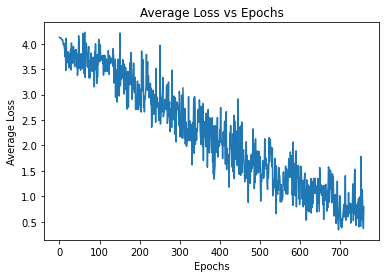

In [ ]:

#Training for normal CNN
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

# Define the loss function.
loss_func = nn.CrossEntropyLoss()

# Define the optimizer.
opt = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
#opt = optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
#opt = optim.Adadelta(net.parameters(), lr=0.001, rho=0.9, eps=1e-06)
#opt = optim.RMSprop(net.parameters(), lr=0.001, weight_decay=1e-6)


avg_losses = []   # Avg. losses.
epochs = 10       # Total epochs.
print_freq = 1  # Print frequency.

for epoch in range(epochs):  # Loop over the dataset multiple times.
    running_loss = 0.0       # Initialize running loss.
    pbar = tqdm(trainloader, desc=f"Epoch {epoch}") # Create a progress bar
    for i, data in enumerate(pbar):
        # Get the inputs.
        inputs, labels = data
        
        # Move the inputs to the specified device.
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients.
        opt.zero_grad()

        # Forward step.
        outputs = net(inputs)
        loss = loss_func(outputs, labels)
        
        # Backward step.
        loss.backward()
        
        # Optimization step (update the parameters).
        opt.step()

        # Print statistics.
        running_loss += loss.item()
        pbar.set_postfix({"Avg Loss": f"{running_loss / (i+1):.3f}"}) # Update the progress bar
        if i % print_freq == print_freq - 1: # Print every several mini-batches.
            avg_loss = running_loss / print_freq
            print('[epoch: {}, i: {:5d}] avg mini-batch loss: {:.3f}'.format(
                epoch, i, avg_loss))
            avg_losses.append(avg_loss)
            running_loss = 0.0

print('Finished Training.')

# Plot the average loss graph.
plt.figure()
plt.plot(avg_losses)
plt.title('Average Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Average Loss')
plt.show()




In [ ]:
#print(avg_losses)

In [ ]:
from sklearn.metrics import accuracy_score

#@title Default title text
y_pred = []
y_true = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        y_pred += predicted.tolist()
        y_true += labels.tolist()

accuracy = accuracy_score(y_true, y_pred)
print('Accuracy of the network on the test images: %d %%' % (100 * accuracy))

Accuracy of the network on the test images: 55 %


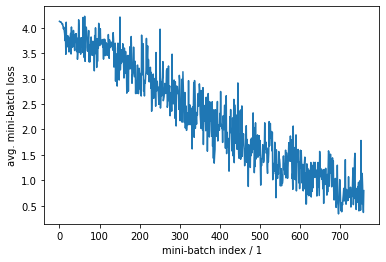

In [ ]:
plt.plot(avg_losses)
plt.xlabel('mini-batch index / {}'.format(print_freq))
plt.ylabel('avg. mini-batch loss')
plt.show()

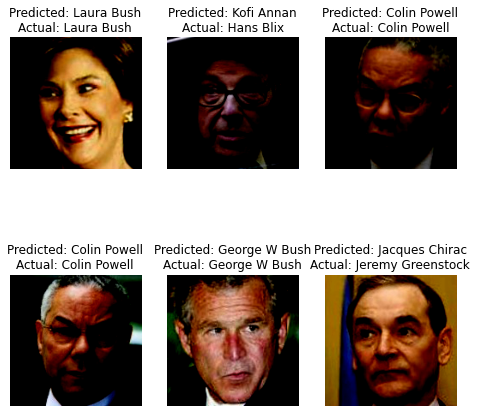

In [ ]:
target_names = lfw_people.target_names
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(8, 8))
net.eval() # set the network to evaluation mode
with torch.no_grad(): # no need to calculate gradients during prediction
    for i in range(6):
        ax = axs[i // 3, i % 3]
        img = test_X[i].unsqueeze(0).to(device) # get the image and move it to the specified device
        label = test_y[i]
        output = net(img) # forward pass
        pred = torch.argmax(output, dim=1) # get the predicted label
        ax.imshow(test_X[i].permute(1, 2, 0))
        ax.set_title(f"Predicted: {target_names[pred.item()]}\nActual: {target_names[label.item()]}")
        ax.axis('off')
plt.show()



In [ ]:
from torchsummary import summary

net = Net()
net.to(device)

summary(net, input_size=(3, 154, 154))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 154, 154]             448
         MaxPool2d-2           [-1, 16, 77, 77]               0
            Conv2d-3           [-1, 32, 77, 77]           4,640
         MaxPool2d-4           [-1, 32, 38, 38]               0
            Conv2d-5           [-1, 64, 38, 38]          18,496
         MaxPool2d-6           [-1, 64, 19, 19]               0
            Linear-7                  [-1, 512]      11,829,760
           Dropout-8                  [-1, 512]               0
            Linear-9                   [-1, 62]          31,806
Total params: 11,885,150
Trainable params: 11,885,150
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.27
Forward/backward pass size (MB): 6.31
Params size (MB): 45.34
Estimated Total Size (MB): 51.92
-----------------------------------